# Import Necessary Packages

In [38]:
# General
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import time
from collections import Counter
import sys
import os
import datetime
from scipy.spatial.distance import hamming
import seaborn as sb
import scipy as sp

code_folder = os.getcwd()
path_to_functions = os.path.join(code_folder, '..')
sys.path.insert(0, path_to_functions)

import functions as funcs
import importlib
importlib.reload(funcs)


<module 'functions' from '/home/fahimeh/Published Codes/causality_whole_brain_hcp/Simulated fMRI Causality/../functions.py'>

# Global Variables

In [2]:
alpha = [0.005, 0.01, 0.05, 0.1, 0.15, 0.3, 0.5, 0.7, 0.9,1]
alpha_dynotears = alpha

alpha_level_pcmci = [1e-20,1e-18,1e-16,1e-14,1e-12,1e-10,1e-8,1e-6,1e-4,1e-2 ]
pc_alpha = 1

tau_max = 2
tau_min = 0

bic_coef_all = [0.005, 0.01, 0.05, 0.1, 0.15, 0.3, 0.5, 0.7, 0.9,1]
mvgc_alpha = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

pc_alpha_pcmciplus = [0.01, 0.2, 0.4, 0.6, 0.8 , 1]

num_simple_networks = 9
num_rep_MTL = 23
num_rep_macaque = 60
num_rep_simple_net = 60
Net = 0

Net_labels = ['Net %d'%i for i in range(1,num_simple_networks+1)]

# Set the Path to External Packages and Files, Results, and Data

In [3]:
code_folder = os.getcwd()
files_folder = os.path.join(code_folder, '..', 'External Packages and Files')
results_folder = os.path.join(code_folder, '..', 'Results')
data_folder = os.path.join(code_folder, '..', 'Data')

# Load Saved Results

In [4]:
def import_npz(npz_file):
    Data = np.load(npz_file, allow_pickle= True)
    print(Data)
    for varName in Data:
        globals()[varName] = Data[varName]  

In [5]:
import_npz(os.path.join(results_folder,'PCMCI_all_simple_nets.npz'))
import_npz(os.path.join(results_folder,'PCMCIPlus_all_simple_nets.npz'))
import_npz(os.path.join(results_folder,'Dynotears_all_simple_nets.npz'))
import_npz(os.path.join(results_folder,'Varlingam_all_simple_nets.npz'))
import_npz(os.path.join(results_folder,'FASK_all_simple_nets.npz')) 
import_npz(os.path.join(results_folder,'DGlearn_all_simple_nets.npz'))
import_npz(os.path.join(results_folder,'mvgc_all_simple_nets.npz'))

## Simulated Simple Networks: Net 1, Net 2,..., Net 9

In [6]:
all_net_nodes_dict = {}
simple_net_all_data = [0]*num_simple_networks

for n in range(0,num_simple_networks):
    path_to_Simple_Net = os.path.join(data_folder,"DataSets_Feedbacks/1_Simple_Networks/Network"+str(n+1)+"_amp/data_fslfilter_concat")

    if n == 7 or n == 8:
       path_to_Simple_Net = os.path.join(data_folder,"DataSets_Feedbacks/1_Simple_Networks/Network"+str(n+1)+"_amp_amp/data_fslfilter_concat")

    simple_net = [0]*num_rep_simple_net

    for i in range (1,num_rep_simple_net + 1):
        if i <= 9:
            current_str = "0"+str(i)
        elif 10 <= i:
            current_str = str(i)

        simple_net [i-1]  = pd.read_csv(path_to_Simple_Net+"/concat_BOLDfslfilter_"+current_str+".txt", delimiter = '\t')

    num_nodes_temp = simple_net [i-1].shape[1]
    nodes_simple_net = ['X%d'%i for i in range(1,num_nodes_temp+1)]
    all_net_nodes_dict[str(n+1)]= nodes_simple_net

    simple_net_all_data[n] = simple_net

    print('nodes in simple network %d :'%(n+1),nodes_simple_net)

nodes in simple network 1 : ['X1', 'X2', 'X3', 'X4', 'X5']
nodes in simple network 2 : ['X1', 'X2', 'X3', 'X4', 'X5']
nodes in simple network 3 : ['X1', 'X2', 'X3', 'X4', 'X5']
nodes in simple network 4 : ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10']
nodes in simple network 5 : ['X1', 'X2', 'X3', 'X4', 'X5']
nodes in simple network 6 : ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']
nodes in simple network 7 : ['X1', 'X2', 'X3', 'X4', 'X5', 'X6']
nodes in simple network 8 : ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']
nodes in simple network 9 : ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9']


## Read Ground Truth Graphs


In [7]:
path_to_ground_truth = os.path.join(data_folder,'DataSets_Feedbacks/1_Simple_Networks/')

ground_truth_nodes_all_networks = [0]*num_simple_networks
ground_truth_edges_all_networks = [0]* num_simple_networks
ground_truth_graph_matrix_all_networks = [0]*num_simple_networks

for n in range(0,num_simple_networks):
    filename = path_to_ground_truth + 'Network%d_amp/graph/Network%d_amp.txt'%(n+1,n+1)
    if n == 7 or n == 8:
        filename = path_to_ground_truth + 'Network%d_amp_amp/graph/Network%d_amp_amp.txt'%(n+1,n+1)
    nodes, edges, graph_matrix, execution_time = funcs.tetrad_graph_parser(filename, ground_truth = 1)
    print('Simple Network %d:'%(n+1),nodes)

    ground_truth_nodes_all_networks[n] = nodes
    ground_truth_edges_all_networks[n] = edges
    ground_truth_graph_matrix_all_networks[n] = graph_matrix

net_size_all = np.zeros((num_simple_networks,1))
net_density_all = np.zeros((num_simple_networks,1))
for n in range(0,num_simple_networks):
    net_size_all[n] = len(ground_truth_nodes_all_networks[n])
    net_density_all[n] = np.mean(ground_truth_graph_matrix_all_networks[n])


Simple Network 1: ['X1', 'X2', 'X3', 'X4', 'X5']
Simple Network 2: ['X1', 'X2', 'X3', 'X4', 'X5']
Simple Network 3: ['X1', 'X2', 'X3', 'X4', 'X5']
Simple Network 4: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10']
Simple Network 5: ['X1', 'X2', 'X3', 'X4', 'X5']
Simple Network 6: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']
Simple Network 7: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6']
Simple Network 8: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']
Simple Network 9: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9']


# Causal Discovery Methods

## FASK

##### Run FASK using system command (causal-cmd)

In [8]:
# for n in range(1, num_simple_networks+1):

# 	for a in range(0,len(alpha)):
		
# 		for r in range(1, num_rep_simple_net+1):

# 			path_to_causal_cmd = os.path.join(files_folder, 'causal-cmd-1.3.0-distribution/causal-cmd-1.3.0/causal-cmd-1.3.0-jar-with-dependencies.jar')

# 			if r < 10:
# 				rep_str = '0'+str(r)
# 			else:
# 				rep_str = str(r)

# 			if n == 8 or n == 9: 

# 				path_to_data = os.path.join(data_folder,'DataSets_Feedbacks/1_Simple_Networks/Network%d_amp_amp/data_fslfilter_concat/concat_BOLDfslfilter_%s.txt'%(n,rep_str))
# 			else: 
# 				path_to_data = os.path.join(data_folder,'DataSets_Feedbacks/1_Simple_Networks/Network%d_amp/data_fslfilter_concat/concat_BOLDfslfilter_%s.txt'%(n,rep_str))

# 			path_to_fask_output = os.path.join(results_folder,'FASK_Simple_Net/Net%d'%n)
# 			os.system('java -jar '+path_to_causal_cmd+ ' --algorithm fask --alpha '+ str(alpha[a])+ ' --data-type continuous --dataset '+path_to_data+' --out '+path_to_fask_output+' --prefix '+ 'Net%d'%n +'-'+ str(alpha[a])+'-%s'%rep_str+' --delimiter tab --test cci-test --verbose No')

##### Read FASK outputs

In [9]:
estimated_FASK_nodes_all_networks = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
estimated_FASK_edges_all_networks = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0, num_simple_networks)]
fask_link_matrix_all_simple_net = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0, num_simple_networks)]
fask_simple_net_execution_time = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]

for n in range(0,num_simple_networks):
    for r in range(0, num_rep_simple_net):
        if r < 9:
            rep = '0'+str(r+1)
        else:
            rep = str(r+1)

        for a in range(0, len(alpha)):

            filename = os.path.join(results_folder,'FASK_Simple_Net/Net%d/Net%d'%(n+1, n+1)+'-'+str(alpha[a])+'-'+rep+'.txt')
            print('Network',n+1,'Repetition:',r+1,'Alpha:',alpha[a])

            nodes, edges, graph_matrix, execution_time = funcs.tetrad_graph_parser(filename, ground_truth = 0)

            estimated_FASK_nodes_all_networks[n][r][a] = nodes
            estimated_FASK_edges_all_networks[n][r][a] = edges
            fask_link_matrix_all_simple_net[n][r][a] = graph_matrix
            fask_simple_net_execution_time[n][r][a] = execution_time

Network 1 Repetition: 1 Alpha: 0.005
2022-08-23 14:09:22 2022-08-23 14:09:39 17.0
Network 1 Repetition: 1 Alpha: 0.01
2022-07-11 13:50:46 2022-07-11 13:51:04 18.0
Network 1 Repetition: 1 Alpha: 0.05
2022-07-11 14:11:43 2022-07-11 14:12:06 23.0
Network 1 Repetition: 1 Alpha: 0.1
2022-07-11 14:35:45 2022-07-11 14:36:09 24.0
Network 1 Repetition: 1 Alpha: 0.15
2022-07-11 15:01:16 2022-07-11 15:01:39 23.0
Network 1 Repetition: 1 Alpha: 0.3
2022-07-11 15:27:53 2022-07-11 15:28:20 27.0
Network 1 Repetition: 1 Alpha: 0.5
2022-07-11 15:57:03 2022-07-11 15:57:30 27.0
Network 1 Repetition: 1 Alpha: 0.7
2022-07-11 16:27:38 2022-07-11 16:28:09 31.0
Network 1 Repetition: 1 Alpha: 0.9
2022-07-11 16:59:17 2022-07-11 16:59:47 30.0
Network 1 Repetition: 1 Alpha: 1
2022-07-11 17:31:00 2022-07-11 17:31:30 30.0
Network 1 Repetition: 2 Alpha: 0.005
2022-07-11 13:26:18 2022-07-11 13:26:52 34.0
Network 1 Repetition: 2 Alpha: 0.01
2022-07-11 13:51:06 2022-07-11 13:51:31 25.0
Network 1 Repetition: 2 Alpha: 0.0

### Plot execution time for FASK for different networks and different values of alpha


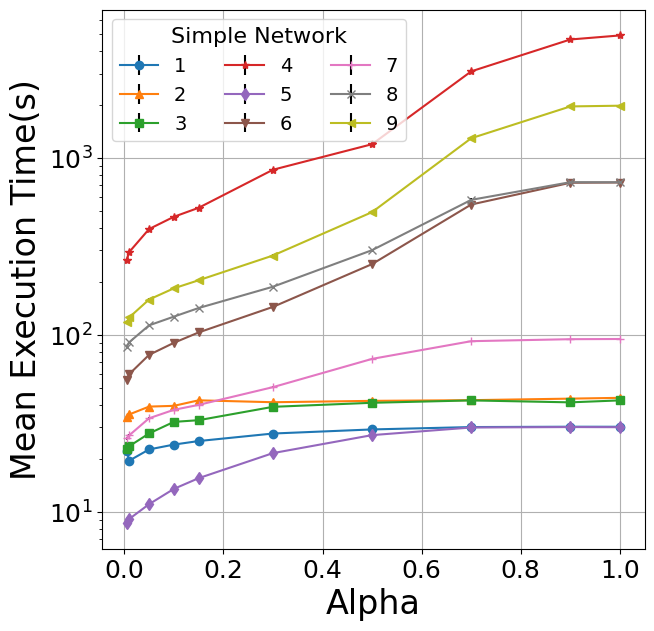

In [10]:
FASK_Mean_Exe_Time = np.zeros((num_simple_networks, len(alpha)))
FASK_std_Exe_Time = np.zeros((num_simple_networks, len(alpha)))
for n in range(0, num_simple_networks):
    for a in range(0, len(alpha)):
        FASK_Mean_Exe_Time[n,a] = np.mean(np.array(fask_simple_net_execution_time[n])[:,a])
        FASK_std_Exe_Time[n,a] = np.std(np.array(fask_simple_net_execution_time[n])[:,a])

markers = ['o-', '^-', 's-', '*-', 'd-', 'v-','+-','x-','<-']
plt.figure(figsize = (7,7))
for n in range(0, num_simple_networks):
    plt.errorbar(alpha, FASK_Mean_Exe_Time[n,:], FASK_std_Exe_Time[n,:]/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])

plt.yscale('log')
plt.xlabel('Alpha', fontsize = 24)
plt.ylabel('Mean Execution Time(s)', fontsize = 24)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.grid()

plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'upper left', ncol = 3, title = 'Simple Network', title_fontsize = 16)


### FASK Performance

In [11]:
fask_adj_TPR_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_rep_simple_net )]
fask_adj_FPR_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_rep_simple_net )]
fask_adj_Recall_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_rep_simple_net )]
fask_adj_Precision_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_rep_simple_net )]
fask_adj_F1_score_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_rep_simple_net )]

fask_ori_TPR_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_rep_simple_net )]
fask_ori_FPR_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_rep_simple_net )]
fask_ori_Recall_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_rep_simple_net )]
fask_ori_Precision_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_rep_simple_net )]
fask_ori_F1_score_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_rep_simple_net )]


for n in range(0,num_simple_networks):
    for r in range(0, num_rep_simple_net):
        for a in range(0, len(alpha)):
           
                true_graph_matrix = np.array(ground_truth_graph_matrix_all_networks[n])
                estimated_graph_matrix = np.array(fask_link_matrix_all_simple_net[n][r][a])
                
                adjacency_TPR, adjacency_FPR, adjacency_Recall, adjacency_Precision, adjacency_F1_score, orientation_TPR, orientation_FPR, orientation_Recall,orientation_Precision,orientation_F1_score = funcs.find_tpr_fpr_from_binary_matrix(true_graph_matrix, estimated_graph_matrix)

                fask_adj_TPR_all_rep[n][r][a] = adjacency_TPR
                fask_adj_FPR_all_rep[n][r][a] = adjacency_FPR
                fask_adj_Recall_all_rep[n][r][a] = adjacency_Recall
                fask_adj_Precision_all_rep[n][r][a] = adjacency_Precision
                fask_adj_F1_score_all_rep[n][r][a] = adjacency_F1_score

                fask_ori_TPR_all_rep[n][r][a] = orientation_TPR
                fask_ori_FPR_all_rep[n][r][a] = orientation_FPR
                fask_ori_Recall_all_rep[n][r][a] = orientation_Recall
                fask_ori_Precision_all_rep[n][r][a] = orientation_Precision
                fask_ori_F1_score_all_rep[n][r][a] = orientation_F1_score


### Recall, Precision, and F1 score with Error Bars for different values of alpha

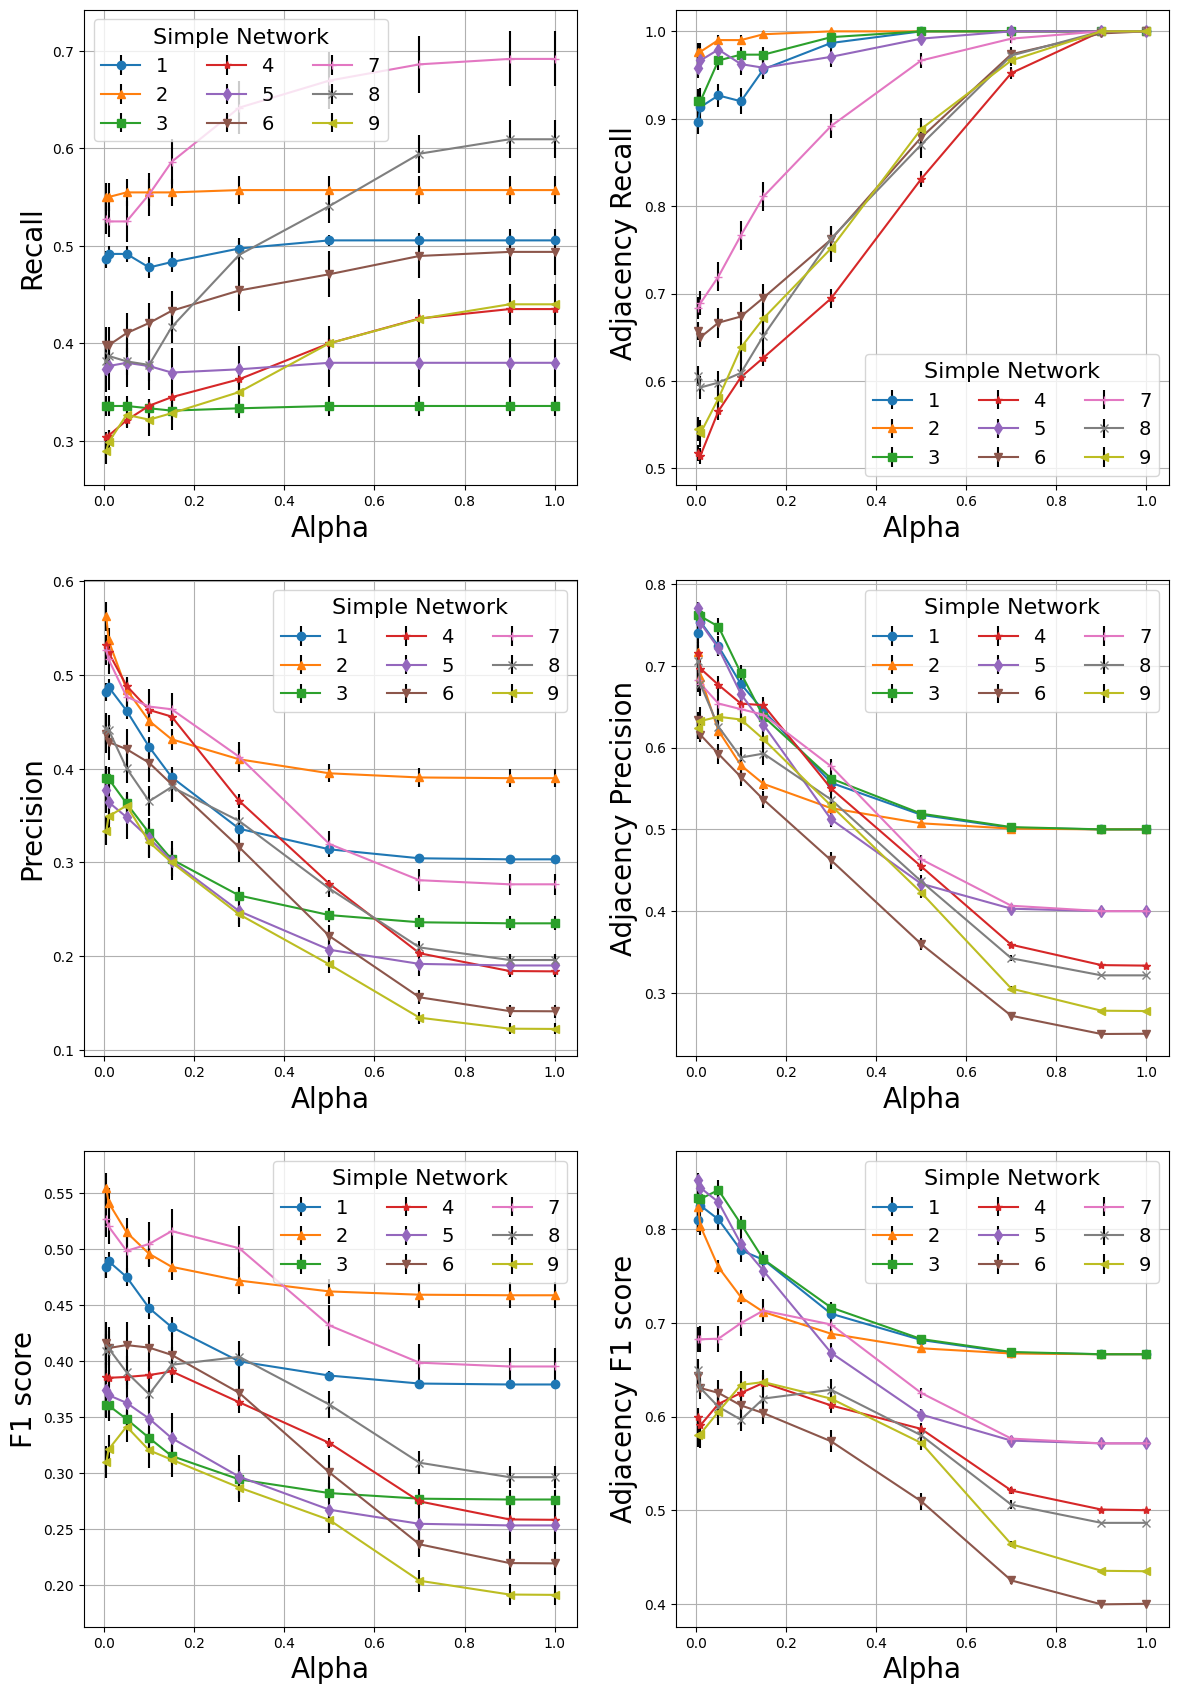

In [12]:
# Recall and Precision, and F1_score vs alpha for adjacency
plt.figure(figsize = (14, 21))

fask_best_alpha_adj_mean = np.zeros((num_simple_networks,1))
fask_best_alpha_adj_median = np.zeros((num_simple_networks,1))
fask_best_alpha_ori_mean = np.zeros((num_simple_networks,1))
fask_best_alpha_ori_median = np.zeros((num_simple_networks,1))

for n in range(0, num_simple_networks):
    
    fask_adj_recall_mean = np.zeros_like(alpha)
    fask_adj_recall_std = np.zeros_like(alpha)
    fask_adj_recall_median = np.zeros_like(alpha)

    fask_adj_precision_mean = np.zeros_like(alpha) 
    fask_adj_precision_std = np.zeros_like(alpha)
    fask_adj_precision_median = np.zeros_like(alpha) 

    fask_adj_F1_score_mean = np.zeros_like(alpha) 
    fask_adj_F1_score_std = np.zeros_like(alpha)
    fask_adj_F1_score_median = np.zeros_like(alpha) 

    fask_ori_recall_mean = np.zeros_like(alpha)
    fask_ori_recall_std = np.zeros_like(alpha)
    fask_ori_recall_median = np.zeros_like(alpha)

    fask_ori_precision_mean = np.zeros_like(alpha)
    fask_ori_precision_std = np.zeros_like(alpha)
    fask_ori_precision_median = np.zeros_like(alpha)

    fask_ori_F1_score_mean = np.zeros_like(alpha)
    fask_ori_F1_score_std = np.zeros_like(alpha)
    fask_ori_F1_score_median = np.zeros_like(alpha)

    for a in range(0,len(alpha)):

        fask_adj_recall_mean[a] = np.mean(np.array(fask_adj_Recall_all_rep[n])[:,a])
        fask_adj_recall_std[a] = np.std(np.array(fask_adj_Recall_all_rep[n])[:,a])
        fask_adj_recall_median[a] = np.median(np.array(fask_adj_Recall_all_rep[n])[:,a])

        fask_adj_precision_mean[a] = np.mean(np.array(fask_adj_Precision_all_rep[n])[:,a])
        fask_adj_precision_std[a] = np.std(np.array(fask_adj_Precision_all_rep[n])[:,a])
        fask_adj_precision_median[a] = np.median(np.array(fask_adj_Precision_all_rep[n])[:,a])

        fask_adj_F1_score_mean[a] = np.mean(np.array(fask_adj_F1_score_all_rep[n])[:,a])
        fask_adj_F1_score_std[a] = np.std(np.array(fask_adj_F1_score_all_rep[n])[:,a])
        fask_adj_F1_score_median[a] = np.median(np.array(fask_adj_F1_score_all_rep[n])[:,a])

        fask_ori_recall_mean[a] = np.mean(np.array(fask_ori_Recall_all_rep[n])[:,a])
        fask_ori_recall_std[a] = np.std(np.array(fask_ori_Recall_all_rep[n])[:,a])
        fask_ori_recall_median[a] = np.median(np.array(fask_ori_Recall_all_rep[n])[:,a])

        fask_ori_precision_mean[a] = np.mean(np.array(fask_ori_Precision_all_rep[n])[:,a])
        fask_ori_precision_std[a] = np.std(np.array(fask_ori_Precision_all_rep[n])[:,a])
        fask_ori_precision_median[a] = np.median(np.array(fask_ori_Precision_all_rep[n])[:,a])

        fask_ori_F1_score_mean[a] = np.mean(np.array(fask_ori_F1_score_all_rep[n])[:,a])
        fask_ori_F1_score_std[a] = np.std(np.array(fask_ori_F1_score_all_rep[n])[:,a])
        fask_ori_F1_score_median[a] = np.median(np.array(fask_ori_F1_score_all_rep[n])[:,a])

    fask_best_alpha_adj_mean[n] = alpha[np.argmax(fask_adj_F1_score_mean)]
    fask_best_alpha_adj_median[n] = alpha[np.argmax(fask_adj_F1_score_median)]
    fask_best_alpha_ori_mean[n] = alpha[np.argmax(fask_ori_F1_score_mean)]
    fask_best_alpha_ori_median[n] = alpha[np.argmax(fask_ori_F1_score_median)]

    plt.subplot(3,2,2)
    plt.errorbar(alpha, fask_adj_recall_mean, fask_adj_recall_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel(' Adjacency Recall', fontsize = 20)
    plt.grid()
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,1)
    plt.errorbar(alpha, fask_ori_recall_mean, fask_ori_recall_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('Recall', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,4)
    plt.errorbar(alpha, fask_adj_precision_mean, fask_adj_precision_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('Adjacency Precision', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,3)
    plt.errorbar(alpha, fask_ori_precision_mean, fask_ori_precision_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('Precision', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,6)
    plt.errorbar(alpha, fask_adj_F1_score_mean, fask_adj_F1_score_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('Adjacency F1 score', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,5)
    plt.errorbar(alpha, fask_ori_F1_score_mean, fask_ori_F1_score_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('F1 score', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


## PCMCI

### Plot execution time for PCMCI for different networks and different values of alpha

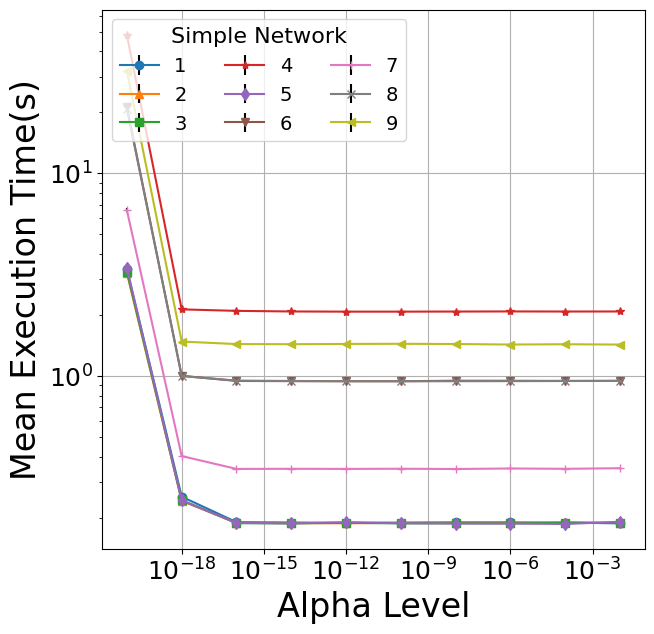

In [13]:
PCMCI_Mean_Exe_Time = np.zeros((num_simple_networks, len(alpha_level_pcmci)))
PCMCI_std_Exe_Time = np.zeros((num_simple_networks, len(alpha_level_pcmci)))
for n in range(0, num_simple_networks):
    for a in range(0, len(alpha_level_pcmci)):
        PCMCI_Mean_Exe_Time[n,a] = np.mean(np.array(pcmci_simple_net_execution_time[n])[:,a])
        PCMCI_std_Exe_Time[n,a] = np.std(np.array(pcmci_simple_net_execution_time[n])[:,a])

markers = ['o-', '^-', 's-', '*-', 'd-', 'v-','+-','x-','<-']
plt.figure(figsize = (7,7))
for n in range(0, num_simple_networks):
    plt.errorbar(alpha_level_pcmci, PCMCI_Mean_Exe_Time[n,:], PCMCI_std_Exe_Time[n,:]/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Alpha Level', fontsize = 24)
plt.ylabel('Mean Execution Time(s)', fontsize = 24)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.grid()

plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'upper left', ncol = 3, title = 'Simple Network', title_fontsize = 16)

#### PCMCI Performance

In [14]:
pcmci_adj_TPR_all_rep = [[['' for t in range(0, len(alpha_level_pcmci))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
pcmci_adj_FPR_all_rep = [[['' for t in range(0, len(alpha_level_pcmci))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
pcmci_adj_Recall_all_rep = [[['' for t in range(0, len(alpha_level_pcmci))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
pcmci_adj_Precision_all_rep = [[['' for t in range(0, len(alpha_level_pcmci))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
pcmci_adj_F1_score_all_rep = [[['' for t in range(0, len(alpha_level_pcmci))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]

pcmci_ori_TPR_all_rep = [[['' for t in range(0, len(alpha_level_pcmci))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
pcmci_ori_FPR_all_rep = [[['' for t in range(0, len(alpha_level_pcmci))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
pcmci_ori_Recall_all_rep = [[['' for t in range(0, len(alpha_level_pcmci))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
pcmci_ori_Precision_all_rep = [[['' for t in range(0, len(alpha_level_pcmci))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
pcmci_ori_F1_score_all_rep = [[['' for t in range(0, len(alpha_level_pcmci))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]

for n in range(0, num_simple_networks):
    for r in range(0,num_rep_simple_net):
        for a in range(0, len(alpha_level_pcmci)):

            ground_truth = ground_truth_graph_matrix_all_networks[n]
            
            PAG = np.array(pcmci_link_matrix_all_simple_net[n][r][a])
            estimated_non_zero_lags_combined = funcs.summarize_across_nonzero_lags(PAG)

            adjacency_TPR, adjacency_FPR, adjacency_Recall, adjacency_Precision, adjacency_F1_score, orientation_TPR, orientation_FPR, orientation_Recall,orientation_Precision,orientation_F1_score = funcs.find_tpr_fpr_from_binary_matrix(ground_truth, estimated_non_zero_lags_combined)

            pcmci_adj_TPR_all_rep[n][r][a] = adjacency_TPR
            pcmci_adj_FPR_all_rep[n][r][a]  = adjacency_FPR
            pcmci_adj_Recall_all_rep[n][r][a]  = adjacency_Recall
            pcmci_adj_Precision_all_rep[n][r][a] = adjacency_Precision
            pcmci_adj_F1_score_all_rep[n][r][a]  = adjacency_F1_score

            pcmci_ori_TPR_all_rep[n][r][a]  = orientation_TPR
            pcmci_ori_FPR_all_rep [n][r][a] = orientation_FPR
            pcmci_ori_Recall_all_rep[n][r][a] = orientation_Recall
            pcmci_ori_Precision_all_rep[n][r][a]  = orientation_Precision
            pcmci_ori_F1_score_all_rep[n][r][a]  = orientation_F1_score

### Recall, Precision, and F1 score with Error Bars for different values of alpha

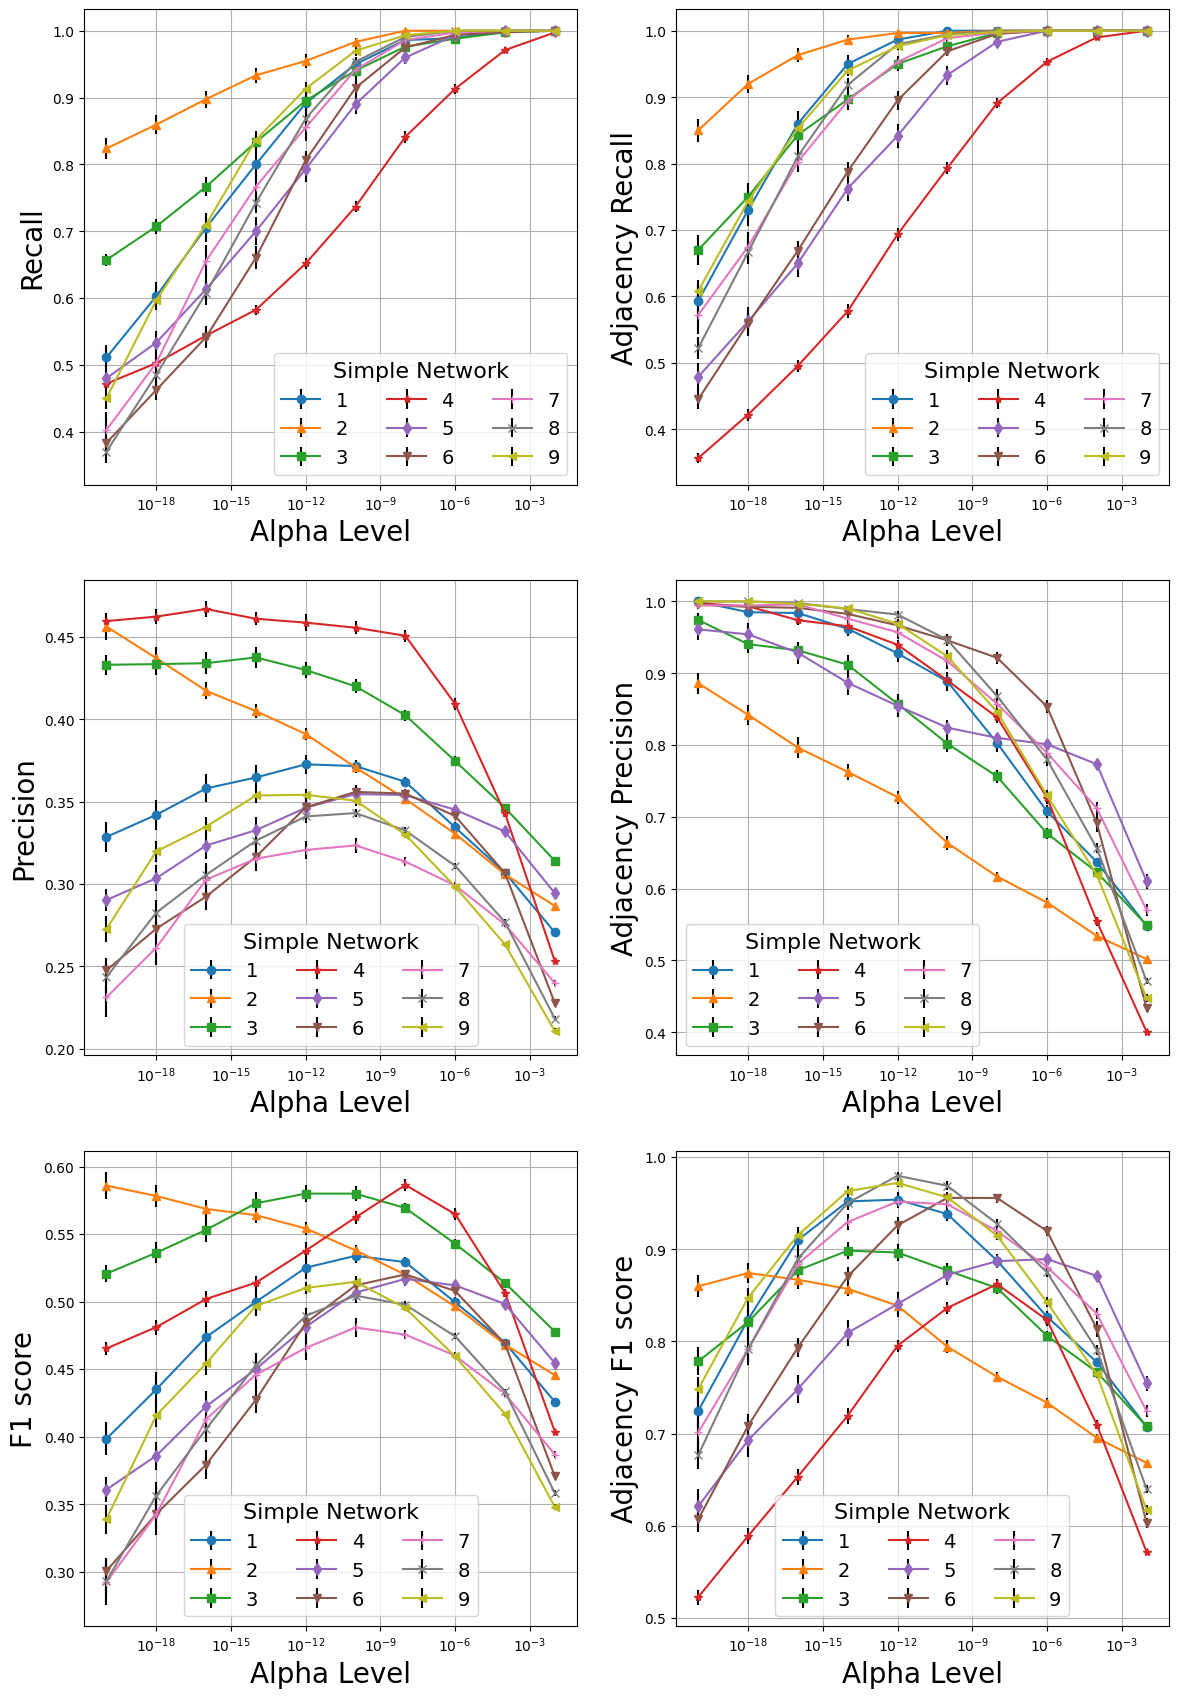

In [15]:
# Recall and Precision, and F1_score vs alpha for adjacency
# error bar
pcmci_best_alpha_adj_mean = np.zeros((num_simple_networks,1))
pcmci_best_alpha_adj_median = np.zeros((num_simple_networks,1))
pcmci_best_alpha_ori_mean = np.zeros((num_simple_networks,1))
pcmci_best_alpha_ori_median = np.zeros((num_simple_networks,1))

plt.figure(figsize = (14, 21))

for n in range(0,num_simple_networks):

    pcmci_adj_recall_mean = np.zeros_like(alpha_level_pcmci)
    pcmci_adj_recall_std = np.zeros_like(alpha_level_pcmci)
    pcmci_adj_recall_median = np.zeros_like(alpha_level_pcmci)


    pcmci_adj_precision_mean = np.zeros_like(alpha_level_pcmci) 
    pcmci_adj_precision_std = np.zeros_like(alpha_level_pcmci)
    pcmci_adj_precision_median = np.zeros_like(alpha_level_pcmci) 


    pcmci_adj_F1_score_mean = np.zeros_like(alpha_level_pcmci) 
    pcmci_adj_F1_score_std = np.zeros_like(alpha_level_pcmci)
    pcmci_adj_F1_score_median = np.zeros_like(alpha_level_pcmci) 


    pcmci_ori_recall_mean = np.zeros_like(alpha_level_pcmci)
    pcmci_ori_recall_std = np.zeros_like(alpha_level_pcmci)
    pcmci_ori_recall_median = np.zeros_like(alpha_level_pcmci)


    pcmci_ori_precision_mean = np.zeros_like(alpha_level_pcmci)
    pcmci_ori_precision_std = np.zeros_like(alpha_level_pcmci)
    pcmci_ori_precision_median = np.zeros_like(alpha_level_pcmci)


    pcmci_ori_F1_score_mean = np.zeros_like(alpha_level_pcmci)
    pcmci_ori_F1_score_std =np.zeros_like(alpha_level_pcmci)
    pcmci_ori_F1_score_median = np.zeros_like(alpha_level_pcmci)


    for a in range(0,len(alpha_level_pcmci)):

        pcmci_adj_recall_mean[a] = np.mean(np.array(pcmci_adj_Recall_all_rep[n])[:,a])
        pcmci_adj_recall_std[a] = np.std(np.array(pcmci_adj_Recall_all_rep[n])[:,a])
        pcmci_adj_recall_median[a] = np.median(np.array(pcmci_adj_Recall_all_rep[n])[:,a])


        pcmci_adj_precision_mean[a] = np.mean(np.array(pcmci_adj_Precision_all_rep[n])[:,a])
        pcmci_adj_precision_std[a] = np.std(np.array(pcmci_adj_Precision_all_rep[n])[:,a])
        pcmci_adj_precision_median[a] = np.median(np.array(pcmci_adj_Precision_all_rep[n])[:,a])


        pcmci_adj_F1_score_mean[a] = np.mean(np.array(pcmci_adj_F1_score_all_rep[n])[:,a])
        pcmci_adj_F1_score_std[a] = np.std(np.array(pcmci_adj_F1_score_all_rep[n])[:,a])
        pcmci_adj_F1_score_median[a] = np.median(np.array(pcmci_adj_F1_score_all_rep[n])[:,a])


        pcmci_ori_recall_mean[a] = np.mean(np.array(pcmci_ori_Recall_all_rep[n])[:,a])
        pcmci_ori_recall_std[a] = np.std(np.array(pcmci_ori_Recall_all_rep[n])[:,a])
        pcmci_ori_recall_median[a] = np.median(np.array(pcmci_ori_Recall_all_rep[n])[:,a])


        pcmci_ori_precision_mean[a] = np.mean(np.array(pcmci_ori_Precision_all_rep[n])[:,a])
        pcmci_ori_precision_std[a] = np.std(np.array(pcmci_ori_Precision_all_rep[n])[:,a])
        pcmci_ori_precision_median[a] = np.median(np.array(pcmci_ori_Precision_all_rep[n])[:,a])


        pcmci_ori_F1_score_mean[a] = np.mean(np.array(pcmci_ori_F1_score_all_rep[n])[:,a])
        pcmci_ori_F1_score_std[a] = np.std(np.array(pcmci_ori_F1_score_all_rep[n])[:,a])
        pcmci_ori_F1_score_median[a] = np.median(np.array(pcmci_ori_F1_score_all_rep[n])[:,a])

    pcmci_best_alpha_adj_mean[n] = alpha_level_pcmci[np.argmax(pcmci_adj_F1_score_mean)]
    pcmci_best_alpha_adj_median[n] = alpha_level_pcmci[np.argmax(pcmci_adj_F1_score_median)]
    pcmci_best_alpha_ori_mean[n] = alpha_level_pcmci[np.argmax(pcmci_ori_F1_score_mean)]
    pcmci_best_alpha_ori_median[n] = alpha_level_pcmci[np.argmax(pcmci_ori_F1_score_median)]

    plt.subplot(3,2,2)
    plt.errorbar(alpha_level_pcmci, pcmci_adj_recall_mean, pcmci_adj_recall_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('Adjacency Recall', fontsize = 20)
    plt.grid()
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,1)
    plt.errorbar(alpha_level_pcmci, pcmci_ori_recall_mean, pcmci_ori_recall_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('Recall', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,4)
    plt.errorbar(alpha_level_pcmci, pcmci_adj_precision_mean, pcmci_adj_precision_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('Adjacency Precision', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,3)
    plt.errorbar(alpha_level_pcmci, pcmci_ori_precision_mean, pcmci_ori_precision_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('Precision', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,6)
    plt.errorbar(alpha_level_pcmci, pcmci_adj_F1_score_mean, pcmci_adj_F1_score_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('Adjacency F1 score', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)

    plt.subplot(3,2,5)
    plt.errorbar(alpha_level_pcmci, pcmci_ori_F1_score_mean, pcmci_ori_F1_score_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('F1 score', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)

## PCMCIplus

### Execution Time

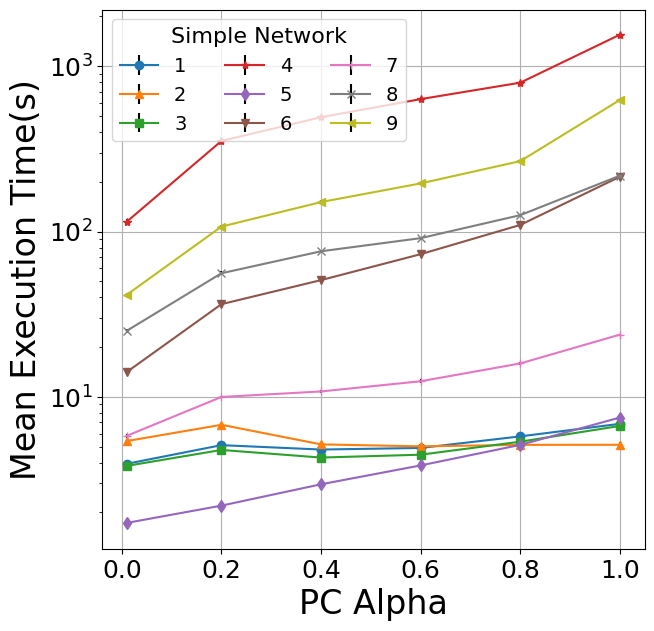

In [16]:
PCMCIplus_Mean_Exe_Time = np.zeros((num_simple_networks, len(pc_alpha_pcmciplus)))
PCMCIplus_std_Exe_Time = np.zeros((num_simple_networks, len(pc_alpha_pcmciplus)))
for n in range(0, num_simple_networks):
    for a in range(0, len(pc_alpha_pcmciplus)):
        PCMCIplus_Mean_Exe_Time[n,a] = np.mean(np.array(pcmciplus_simple_net_execution_time[n])[:,a])
        PCMCIplus_std_Exe_Time[n,a] = np.std(np.array(pcmciplus_simple_net_execution_time[n])[:,a])

markers = ['o-', '^-', 's-', '*-', 'd-', 'v-','+-','x-','<-']
plt.figure(figsize = (7,7))
for n in range(0, num_simple_networks):
    plt.errorbar(pc_alpha_pcmciplus, PCMCIplus_Mean_Exe_Time[n,:], PCMCIplus_std_Exe_Time[n,:]/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])

plt.yscale('log')
plt.xlabel('PC Alpha', fontsize = 24)
plt.ylabel('Mean Execution Time(s)', fontsize = 24)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.grid(visible = True)

plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'upper left', ncol = 3, title = 'Simple Network', title_fontsize = 16)

### PCMCIplus Performance

In [17]:
pcmciplus_adj_TPR_all_rep = [[['' for t in range(0, len(pc_alpha_pcmciplus))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
pcmciplus_adj_FPR_all_rep = [[['' for t in range(0, len(pc_alpha_pcmciplus))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
pcmciplus_adj_Recall_all_rep = [[['' for t in range(0, len(pc_alpha_pcmciplus))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
pcmciplus_adj_Precision_all_rep = [[['' for t in range(0, len(pc_alpha_pcmciplus))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
pcmciplus_adj_F1_score_all_rep = [[['' for t in range(0, len(pc_alpha_pcmciplus))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]

pcmciplus_ori_TPR_all_rep = [[['' for t in range(0, len(pc_alpha_pcmciplus))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
pcmciplus_ori_FPR_all_rep = [[['' for t in range(0, len(pc_alpha_pcmciplus))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
pcmciplus_ori_Recall_all_rep = [[['' for t in range(0, len(pc_alpha_pcmciplus))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
pcmciplus_ori_Precision_all_rep = [[['' for t in range(0, len(pc_alpha_pcmciplus))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
pcmciplus_ori_F1_score_all_rep = [[['' for t in range(0, len(pc_alpha_pcmciplus))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]


estimated_time_lagged_graph = [[['' for t in range(0, len(pc_alpha_pcmciplus))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
estimated_binary_graphs_all = [[['' for t in range(0, len(pc_alpha_pcmciplus))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]

for n in range(0, num_simple_networks):
    for r in range(0,num_rep_simple_net):
        for a in range(0, len(pc_alpha_pcmciplus)):

            ground_truth = ground_truth_graph_matrix_all_networks[n]
                        
            PAG = np.array(pcmciplus_link_matrix_all_simple_net[n][r][a])

            estimated_time_lagged_graph[n][r][a] = PAG
            summary_graph, adjacency_binary_matrix, orientation_binary_matrix = funcs.summarize_across_all_lags_v1(PAG)

            estimated_binary_graphs_all[n][r][a] = orientation_binary_matrix
            adjacency_TPR, adjacency_FPR, adjacency_Recall, adjacency_Precision, adjacency_F1_score, orientation_TPR, orientation_FPR, orientation_Recall,orientation_Precision,orientation_F1_score = funcs.find_tpr_fpr_from_binary_matrix(ground_truth, orientation_binary_matrix)

            pcmciplus_adj_TPR_all_rep[n][r][a] = adjacency_TPR
            pcmciplus_adj_FPR_all_rep[n][r][a]  = adjacency_FPR
            pcmciplus_adj_Recall_all_rep[n][r][a]  = adjacency_Recall
            pcmciplus_adj_Precision_all_rep[n][r][a] = adjacency_Precision
            pcmciplus_adj_F1_score_all_rep[n][r][a]  = adjacency_F1_score

            pcmciplus_ori_TPR_all_rep[n][r][a]  = orientation_TPR
            pcmciplus_ori_FPR_all_rep [n][r][a] = orientation_FPR
            pcmciplus_ori_Recall_all_rep[n][r][a] = orientation_Recall
            pcmciplus_ori_Precision_all_rep[n][r][a]  = orientation_Precision
            pcmciplus_ori_F1_score_all_rep[n][r][a]  = orientation_F1_score

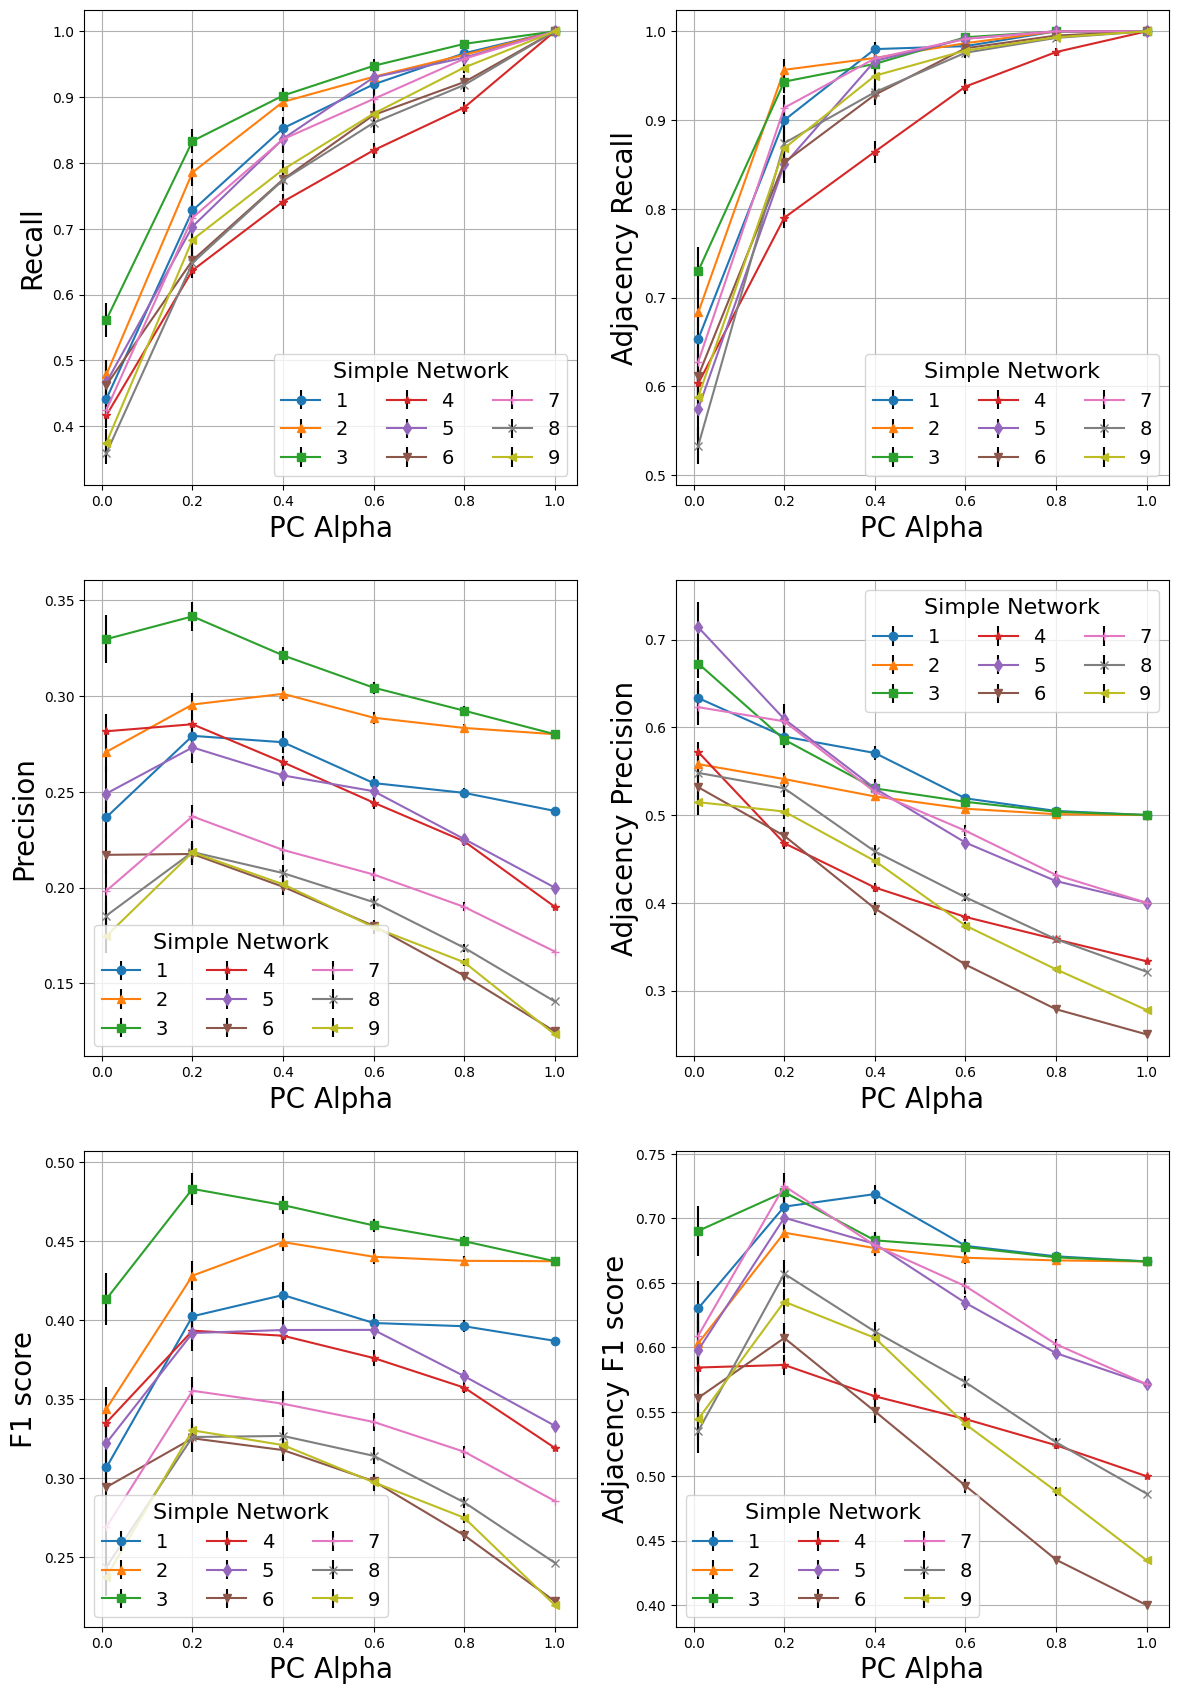

In [18]:
# Recall and Precision, and F1_score vs alpha for adjacency
pcmciplus_best_alpha_adj_mean = np.zeros((num_simple_networks,1))
pcmciplus_best_alpha_adj_median = np.zeros((num_simple_networks,1))
pcmciplus_best_alpha_ori_mean = np.zeros((num_simple_networks,1))
pcmciplus_best_alpha_ori_median = np.zeros((num_simple_networks,1))

plt.figure(figsize = (14, 21))

for n in range(0,num_simple_networks):

    pcmciplus_adj_recall_mean = np.zeros_like(pc_alpha_pcmciplus)
    pcmciplus_adj_recall_std = np.zeros_like(pc_alpha_pcmciplus)
    pcmciplus_adj_recall_median = np.zeros_like(pc_alpha_pcmciplus)

    pcmciplus_adj_precision_mean = np.zeros_like(pc_alpha_pcmciplus) 
    pcmciplus_adj_precision_std = np.zeros_like(pc_alpha_pcmciplus)
    pcmciplus_adj_precision_median = np.zeros_like(pc_alpha_pcmciplus) 

    pcmciplus_adj_F1_score_mean = np.zeros_like(pc_alpha_pcmciplus) 
    pcmciplus_adj_F1_score_std = np.zeros_like(pc_alpha_pcmciplus)
    pcmciplus_adj_F1_score_median = np.zeros_like(pc_alpha_pcmciplus) 


    pcmciplus_ori_recall_mean = np.zeros_like(pc_alpha_pcmciplus)
    pcmciplus_ori_recall_std = np.zeros_like(pc_alpha_pcmciplus)
    pcmciplus_ori_recall_median = np.zeros_like(pc_alpha_pcmciplus)


    pcmciplus_ori_precision_mean = np.zeros_like(pc_alpha_pcmciplus)
    pcmciplus_ori_precision_std = np.zeros_like(pc_alpha_pcmciplus)
    pcmciplus_ori_precision_median = np.zeros_like(pc_alpha_pcmciplus)


    pcmciplus_ori_F1_score_mean = np.zeros_like(pc_alpha_pcmciplus)
    pcmciplus_ori_F1_score_std =np.zeros_like(pc_alpha_pcmciplus)
    pcmciplus_ori_F1_score_median = np.zeros_like(pc_alpha_pcmciplus)


    for a in range(0,len(pc_alpha_pcmciplus)):

        pcmciplus_adj_recall_mean[a] = np.mean(np.array(pcmciplus_adj_Recall_all_rep[n])[:,a])
        pcmciplus_adj_recall_std[a] = np.std(np.array(pcmciplus_adj_Recall_all_rep[n])[:,a])
        pcmciplus_adj_recall_median[a] = np.median(np.array(pcmciplus_adj_Recall_all_rep[n])[:,a])

        pcmciplus_adj_precision_mean[a] = np.mean(np.array(pcmciplus_adj_Precision_all_rep[n])[:,a])
        pcmciplus_adj_precision_std[a] = np.std(np.array(pcmciplus_adj_Precision_all_rep[n])[:,a])
        pcmciplus_adj_precision_median[a] = np.median(np.array(pcmciplus_adj_Precision_all_rep[n])[:,a])

        pcmciplus_adj_F1_score_mean[a] = np.mean(np.array(pcmciplus_adj_F1_score_all_rep[n])[:,a])
        pcmciplus_adj_F1_score_std[a] = np.std(np.array(pcmciplus_adj_F1_score_all_rep[n])[:,a])
        pcmciplus_adj_F1_score_median[a] = np.median(np.array(pcmciplus_adj_F1_score_all_rep[n])[:,a])

        pcmciplus_ori_recall_mean[a] = np.mean(np.array(pcmciplus_ori_Recall_all_rep[n])[:,a])
        pcmciplus_ori_recall_std[a] = np.std(np.array(pcmciplus_ori_Recall_all_rep[n])[:,a])
        pcmciplus_ori_recall_median[a] = np.median(np.array(pcmciplus_ori_Recall_all_rep[n])[:,a])

        pcmciplus_ori_precision_mean[a] = np.mean(np.array(pcmciplus_ori_Precision_all_rep[n])[:,a])
        pcmciplus_ori_precision_std[a] = np.std(np.array(pcmciplus_ori_Precision_all_rep[n])[:,a])
        pcmciplus_ori_precision_median[a] = np.median(np.array(pcmciplus_ori_Precision_all_rep[n])[:,a])

        pcmciplus_ori_F1_score_mean[a] = np.mean(np.array(pcmciplus_ori_F1_score_all_rep[n])[:,a])
        pcmciplus_ori_F1_score_std[a] = np.std(np.array(pcmciplus_ori_F1_score_all_rep[n])[:,a])
        pcmciplus_ori_F1_score_median[a] = np.median(np.array(pcmciplus_ori_F1_score_all_rep[n])[:,a])

    pcmciplus_best_alpha_adj_mean[n] = pc_alpha_pcmciplus[np.argmax(pcmciplus_adj_F1_score_mean)]
    pcmciplus_best_alpha_adj_median[n] = pc_alpha_pcmciplus[np.argmax(pcmciplus_adj_F1_score_median)]
    pcmciplus_best_alpha_ori_mean[n] = pc_alpha_pcmciplus[np.argmax(pcmciplus_ori_F1_score_mean)]
    pcmciplus_best_alpha_ori_median[n] = pc_alpha_pcmciplus[np.argmax(pcmciplus_ori_F1_score_median)]

    plt.subplot(3,2,2)
    plt.errorbar(pc_alpha_pcmciplus, pcmciplus_adj_recall_mean, pcmciplus_adj_recall_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('PC Alpha', fontsize = 20)
    plt.ylabel('Adjacency Recall', fontsize = 20)
    plt.grid()
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)

    plt.subplot(3,2,1)
    plt.errorbar(pc_alpha_pcmciplus, pcmciplus_ori_recall_mean, pcmciplus_ori_recall_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('PC Alpha', fontsize = 20)
    plt.ylabel('Recall', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)

    plt.subplot(3,2,4)
    plt.errorbar(pc_alpha_pcmciplus, pcmciplus_adj_precision_mean, pcmciplus_adj_precision_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('PC Alpha', fontsize = 20)
    plt.ylabel('Adjacency Precision', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)

    plt.subplot(3,2,3)
    plt.errorbar(pc_alpha_pcmciplus, pcmciplus_ori_precision_mean, pcmciplus_ori_precision_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('PC Alpha', fontsize = 20)
    plt.ylabel('Precision', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)

    plt.subplot(3,2,6)
    plt.errorbar(pc_alpha_pcmciplus, pcmciplus_adj_F1_score_mean, pcmciplus_adj_F1_score_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('PC Alpha', fontsize = 20)
    plt.ylabel('Adjacency F1 score', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)

    plt.subplot(3,2,5)
    plt.errorbar(pc_alpha_pcmciplus, pcmciplus_ori_F1_score_mean, pcmciplus_ori_F1_score_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('PC Alpha', fontsize = 20)
    plt.ylabel('F1 score', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)

## Dynotears

### Plot execution time for Dynotears for different networks and different values of alpha

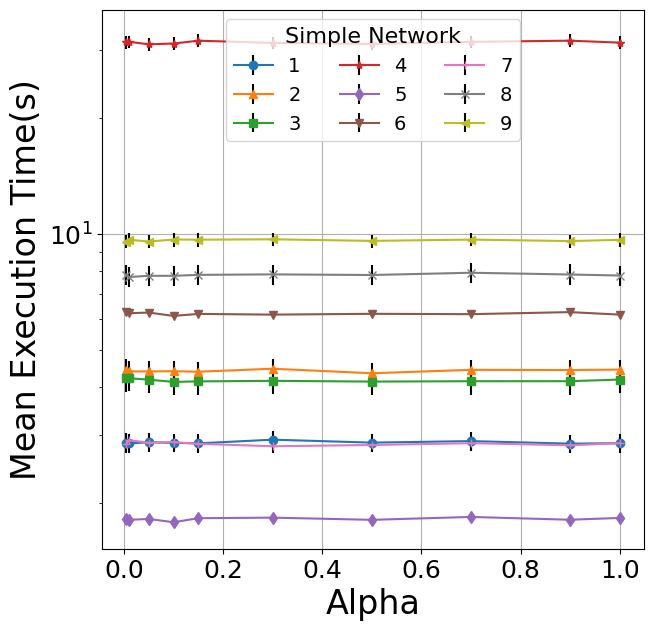

In [19]:
Dynotears_Mean_Exe_Time = np.zeros((num_simple_networks, len(alpha)))
Dynotears_std_Exe_Time = np.zeros((num_simple_networks, len(alpha)))
for n in range(0, num_simple_networks):
    for a in range(0, len(alpha)):
        Dynotears_Mean_Exe_Time[n,a] = np.mean(np.array(dynotears_simple_net_execution_time[n])[:,a])
        Dynotears_std_Exe_Time[n,a] = np.std(np.array(dynotears_simple_net_execution_time[n])[:,a])

markers = ['o-', '^-', 's-', '*-', 'd-', 'v-','+-','x-','<-']
plt.figure(figsize = (7,7))
for n in range(0, num_simple_networks):
    plt.errorbar(alpha, Dynotears_Mean_Exe_Time[n,:], Dynotears_std_Exe_Time[n,:]/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])

plt.yscale('log')
plt.xlabel('Alpha', fontsize = 24)
plt.ylabel('Mean Execution Time(s)', fontsize = 24)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.grid()

plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)

### Dynotears Performance

In [20]:
dynotears_adj_TPR_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
dynotears_adj_FPR_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
dynotears_adj_Recall_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
dynotears_adj_Precision_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
dynotears_adj_F1_score_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]

dynotears_ori_TPR_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
dynotears_ori_FPR_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
dynotears_ori_Recall_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
dynotears_ori_Precision_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
dynotears_ori_F1_score_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]

for n in range(0, num_simple_networks):
    for r in range(0,num_rep_simple_net):
        for a in range(0, len(alpha_dynotears)):

            ground_truth = ground_truth_graph_matrix_all_networks[n]
            
            PAG = np.array(dynotears_link_matrix_all_simple_net[n][r][a])
            summary_graph, adjacency_binary_matrix, orientation_binary_matrix = funcs.summarize_across_all_lags_v1(PAG)

            adjacency_TPR, adjacency_FPR, adjacency_Recall, adjacency_Precision, adjacency_F1_score, orientation_TPR, orientation_FPR, orientation_Recall,orientation_Precision,orientation_F1_score = funcs.find_tpr_fpr_from_binary_matrix(ground_truth, orientation_binary_matrix)

            dynotears_adj_TPR_all_rep[n][r][a] = adjacency_TPR
            dynotears_adj_FPR_all_rep[n][r][a]  = adjacency_FPR
            dynotears_adj_Recall_all_rep[n][r][a]  = adjacency_Recall
            dynotears_adj_Precision_all_rep[n][r][a] = adjacency_Precision
            dynotears_adj_F1_score_all_rep[n][r][a]  = adjacency_F1_score

            dynotears_ori_TPR_all_rep[n][r][a]  = orientation_TPR
            dynotears_ori_FPR_all_rep [n][r][a] = orientation_FPR
            dynotears_ori_Recall_all_rep[n][r][a] = orientation_Recall
            dynotears_ori_Precision_all_rep[n][r][a]  = orientation_Precision
            dynotears_ori_F1_score_all_rep[n][r][a]  = orientation_F1_score

### Recall, Precision, and F1 score with Error Bars for different values of alpha

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


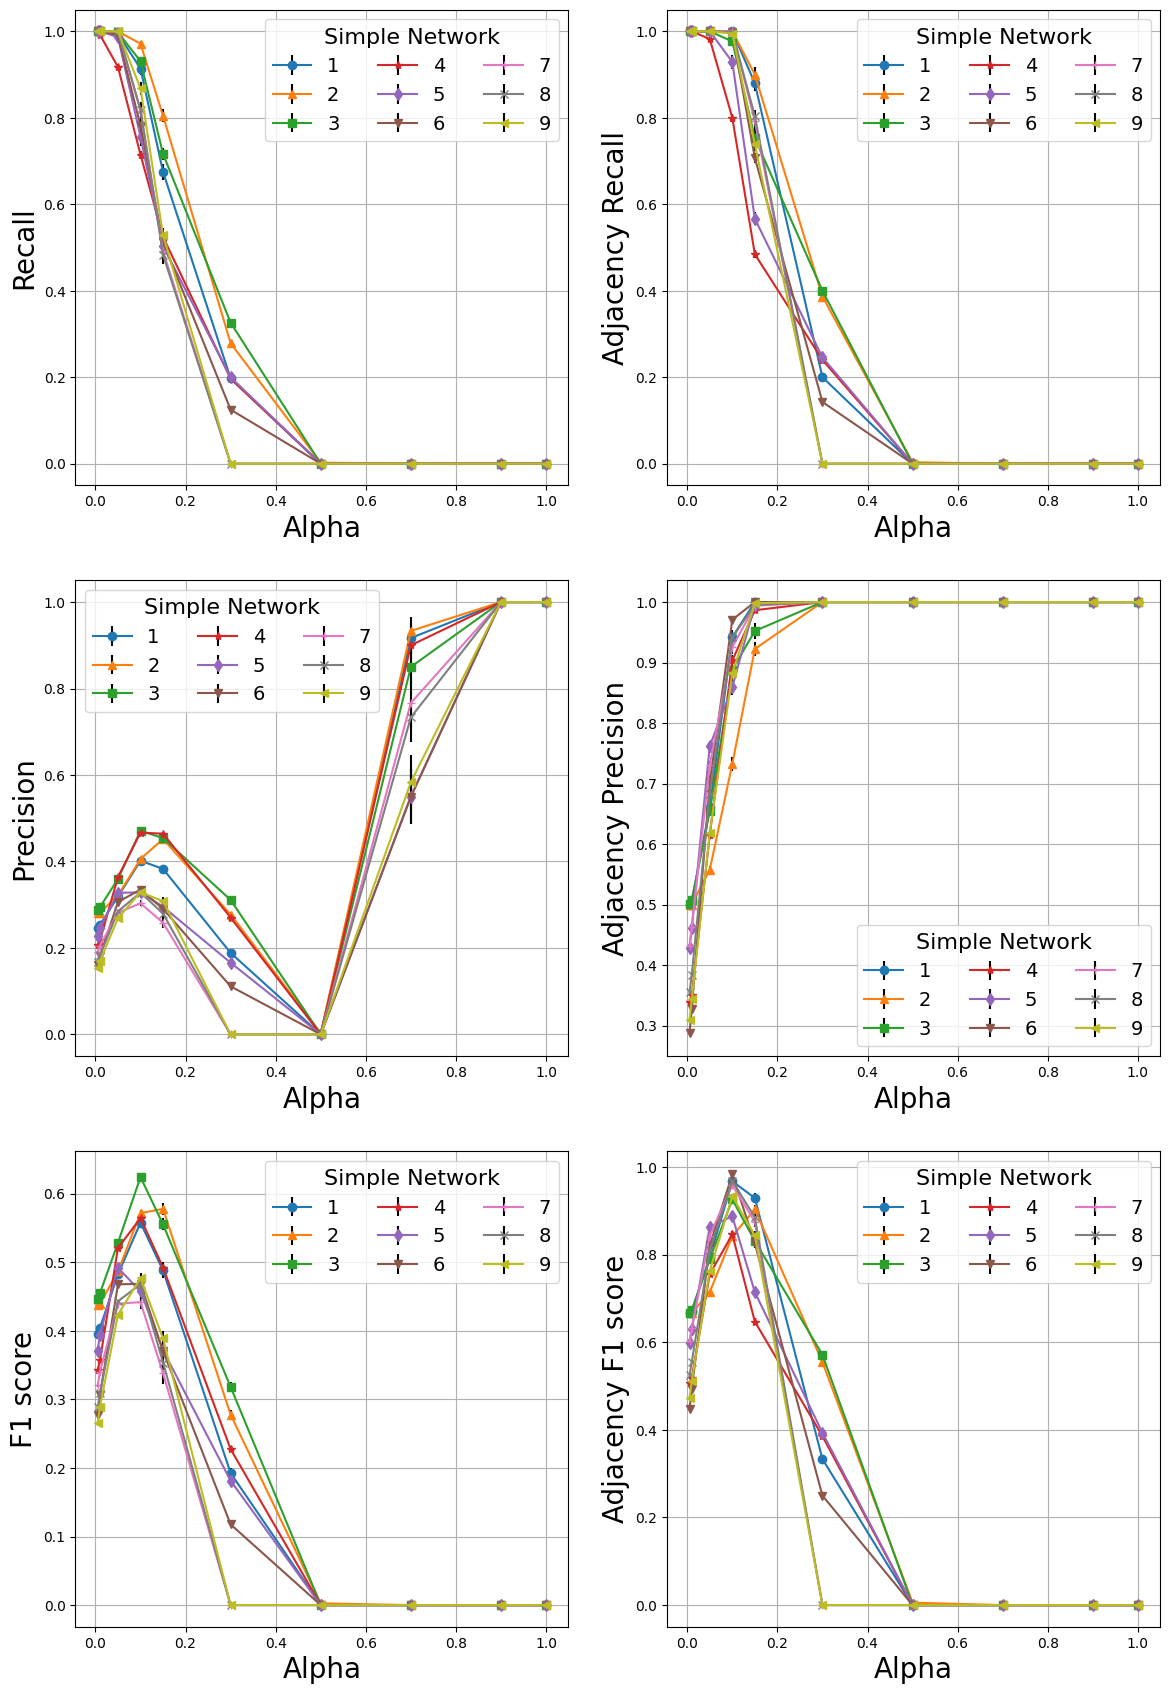

In [21]:
# Recall and Precision, and F1_score vs alpha for adjacency
dynotears_best_alpha_adj_mean = np.zeros((num_simple_networks,1))
dynotears_best_alpha_adj_median = np.zeros((num_simple_networks,1))
dynotears_best_alpha_ori_mean = np.zeros((num_simple_networks,1))
dynotears_best_alpha_ori_median = np.zeros((num_simple_networks,1))

plt.figure(figsize = (14, 21))

for n in range(0, num_simple_networks):
    dynotears_adj_recall_mean = np.zeros_like(alpha_dynotears)
    dynotears_adj_recall_std = np.zeros_like(alpha_dynotears)
    dynotears_adj_recall_median = np.zeros_like(alpha_dynotears)


    dynotears_adj_precision_mean = np.zeros_like(alpha_dynotears) 
    dynotears_adj_precision_std = np.zeros_like(alpha_dynotears)
    dynotears_adj_precision_median = np.zeros_like(alpha_dynotears) 


    dynotears_adj_F1_score_mean = np.zeros_like(alpha_dynotears) 
    dynotears_adj_F1_score_std = np.zeros_like(alpha_dynotears)
    dynotears_adj_F1_score_median = np.zeros_like(alpha_dynotears) 


    dynotears_ori_recall_mean = np.zeros_like(alpha_dynotears)
    dynotears_ori_recall_std = np.zeros_like(alpha_dynotears)
    dynotears_ori_recall_median = np.zeros_like(alpha_dynotears)


    dynotears_ori_precision_mean = np.zeros_like(alpha_dynotears)
    dynotears_ori_precision_std = np.zeros_like(alpha_dynotears)
    dynotears_ori_precision_median = np.zeros_like(alpha_dynotears)


    dynotears_ori_F1_score_mean = np.zeros_like(alpha_dynotears)
    dynotears_ori_F1_score_std =np.zeros_like(alpha_dynotears)
    dynotears_ori_F1_score_median = np.zeros_like(alpha_dynotears)



    for a in range(0,len(alpha_dynotears)):

        dynotears_adj_recall_mean[a] = np.mean(np.array(dynotears_adj_Recall_all_rep[n])[:,a])
        dynotears_adj_recall_std[a] = np.std(np.array(dynotears_adj_Recall_all_rep[n])[:,a])
        dynotears_adj_recall_median[a] = np.median(np.array(dynotears_adj_Recall_all_rep[n])[:,a])


        dynotears_adj_precision_mean[a] = np.mean(np.array(dynotears_adj_Precision_all_rep[n])[:,a])
        dynotears_adj_precision_std[a] = np.std(np.array(dynotears_adj_Precision_all_rep[n])[:,a])
        dynotears_adj_precision_median[a] = np.median(np.array(dynotears_adj_Precision_all_rep[n])[:,a])



        dynotears_adj_F1_score_mean[a] = np.mean(np.array(dynotears_adj_F1_score_all_rep[n])[:,a])
        dynotears_adj_F1_score_std[a] = np.std(np.array(dynotears_adj_F1_score_all_rep[n])[:,a])
        dynotears_adj_F1_score_median[a] = np.median(np.array(dynotears_adj_F1_score_all_rep[n])[:,a])


        dynotears_ori_recall_mean[a] = np.mean(np.array(dynotears_ori_Recall_all_rep[n])[:,a])
        dynotears_ori_recall_std[a] = np.std(np.array(dynotears_ori_Recall_all_rep[n])[:,a])
        dynotears_ori_recall_median[a] = np.median(np.array(dynotears_ori_Recall_all_rep[n])[:,a])


        dynotears_ori_precision_mean[a] = np.mean(np.array(dynotears_ori_Precision_all_rep[n])[:,a])
        dynotears_ori_precision_std[a] = np.std(np.array(dynotears_ori_Precision_all_rep[n])[:,a])
        dynotears_ori_precision_median[a] = np.median(np.array(dynotears_ori_Precision_all_rep[n])[:,a])


        dynotears_ori_F1_score_mean[a] = np.mean(np.array(dynotears_ori_F1_score_all_rep[n])[:,a])
        dynotears_ori_F1_score_std[a] = np.std(np.array(dynotears_ori_F1_score_all_rep[n])[:,a])
        dynotears_ori_F1_score_median[a] = np.median(np.array(dynotears_ori_F1_score_all_rep[n])[:,a])

    dynotears_best_alpha_adj_mean[n] = alpha_dynotears[np.argmax(dynotears_adj_F1_score_mean)]
    dynotears_best_alpha_adj_median[n] = alpha_dynotears[np.argmax(dynotears_adj_F1_score_median)]
    dynotears_best_alpha_ori_mean[n] = alpha_dynotears[np.argmax(dynotears_ori_F1_score_mean)]
    dynotears_best_alpha_ori_median[n] = alpha_dynotears[np.argmax(dynotears_ori_F1_score_median)]

    
    plt.subplot(3,2,2)
    plt.errorbar(alpha, dynotears_adj_recall_mean, dynotears_adj_recall_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('Adjacency Recall', fontsize = 20)
    plt.grid()
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,1)
    plt.errorbar(alpha, dynotears_ori_recall_mean, dynotears_ori_recall_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('Recall', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,4)
    plt.errorbar(alpha, dynotears_adj_precision_mean, dynotears_adj_precision_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('Adjacency Precision', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,3)
    plt.errorbar(alpha, dynotears_ori_precision_mean, dynotears_ori_precision_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('Precision', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,6)
    plt.errorbar(alpha, dynotears_adj_F1_score_mean, dynotears_adj_F1_score_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('Adjacency F1 score', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,5)
    plt.errorbar(alpha, dynotears_ori_F1_score_mean, dynotears_ori_F1_score_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('F1 score', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)
plt.savefig('/home/fahimeh/Volitional_Control_Neurofeedback/Non-DecNef/codes/Causality_Analysis/Codes/resutls for paper/high_quality/supp/simple_nets_dynotears_precision_recall_f1_score.eps', bbox_inches = 'tight', format = 'eps')


## VARLINGAM

### Plot execution time for Varlingam for different networks and different values of alpha

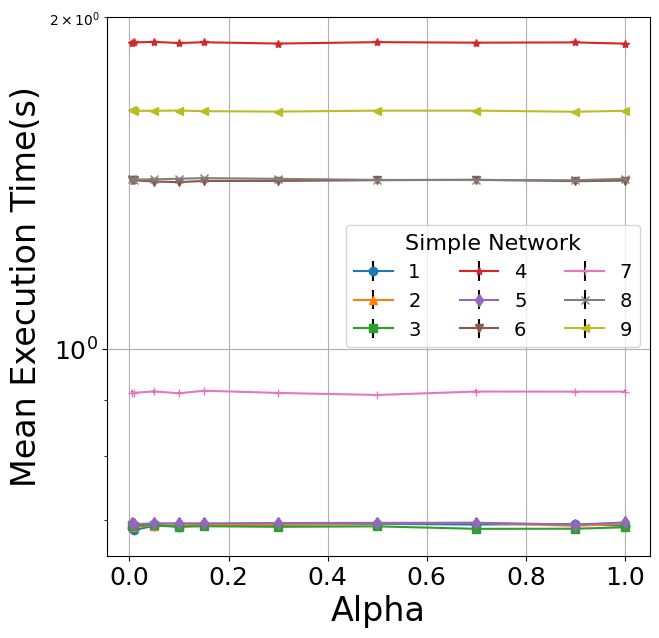

In [22]:
Varlingam_Mean_Exe_Time = np.zeros((num_simple_networks, len(alpha)))
Varlingam_std_Exe_Time = np.zeros((num_simple_networks, len(alpha)))
for n in range(0, num_simple_networks):
    for a in range(0, len(alpha)):
        Varlingam_Mean_Exe_Time[n,a] = np.mean(np.array(varlingam_simple_net_execution_time[n])[:,a])
        Varlingam_std_Exe_Time[n,a] = np.std(np.array(varlingam_simple_net_execution_time[n])[:,a])

markers = ['o-', '^-', 's-', '*-', 'd-', 'v-','+-','x-','<-']
plt.figure(figsize = (7,7))
for n in range(0, num_simple_networks):
    plt.errorbar(alpha, Varlingam_Mean_Exe_Time[n,:], Varlingam_std_Exe_Time[n,:]/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])

plt.yscale('log')
plt.xlabel('Alpha', fontsize = 24)
plt.ylabel('Mean Execution Time(s)', fontsize = 24)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.grid()

plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)

### VARLINGAM Performance

In [23]:
varlingam_adj_TPR_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
varlingam_adj_FPR_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
varlingam_adj_Recall_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
varlingam_adj_Precision_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
varlingam_adj_F1_score_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]

varlingam_ori_TPR_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
varlingam_ori_FPR_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
varlingam_ori_Recall_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
varlingam_ori_Precision_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
varlingam_ori_F1_score_all_rep = [[['' for t in range(0, len(alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]

for n in range(0, num_simple_networks):
    for r in range(0,num_rep_simple_net):
        for a in range(0, len(alpha)):

            ground_truth = ground_truth_graph_matrix_all_networks[n]

            PAG = np.array(varlingam_link_matrix_all_simple_net[n][r][a])
            summary_graph, adjacency_binary_matrix, orientation_binary_matrix = funcs.summarize_across_all_lags_v1(PAG)

            adjacency_TPR, adjacency_FPR, adjacency_Recall, adjacency_Precision, adjacency_F1_score, orientation_TPR, orientation_FPR, orientation_Recall,orientation_Precision,orientation_F1_score = funcs.find_tpr_fpr_from_binary_matrix(ground_truth, orientation_binary_matrix)

            varlingam_adj_TPR_all_rep[n][r][a] = adjacency_TPR
            varlingam_adj_FPR_all_rep[n][r][a]  = adjacency_FPR
            varlingam_adj_Recall_all_rep[n][r][a]  = adjacency_Recall
            varlingam_adj_Precision_all_rep[n][r][a] = adjacency_Precision
            varlingam_adj_F1_score_all_rep[n][r][a]  = adjacency_F1_score

            varlingam_ori_TPR_all_rep[n][r][a]  = orientation_TPR
            varlingam_ori_FPR_all_rep [n][r][a] = orientation_FPR
            varlingam_ori_Recall_all_rep[n][r][a] = orientation_Recall
            varlingam_ori_Precision_all_rep[n][r][a]  = orientation_Precision
            varlingam_ori_F1_score_all_rep[n][r][a]  = orientation_F1_score

### Recall, Precision, and F1 score with Error Bars for different values of alpha

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


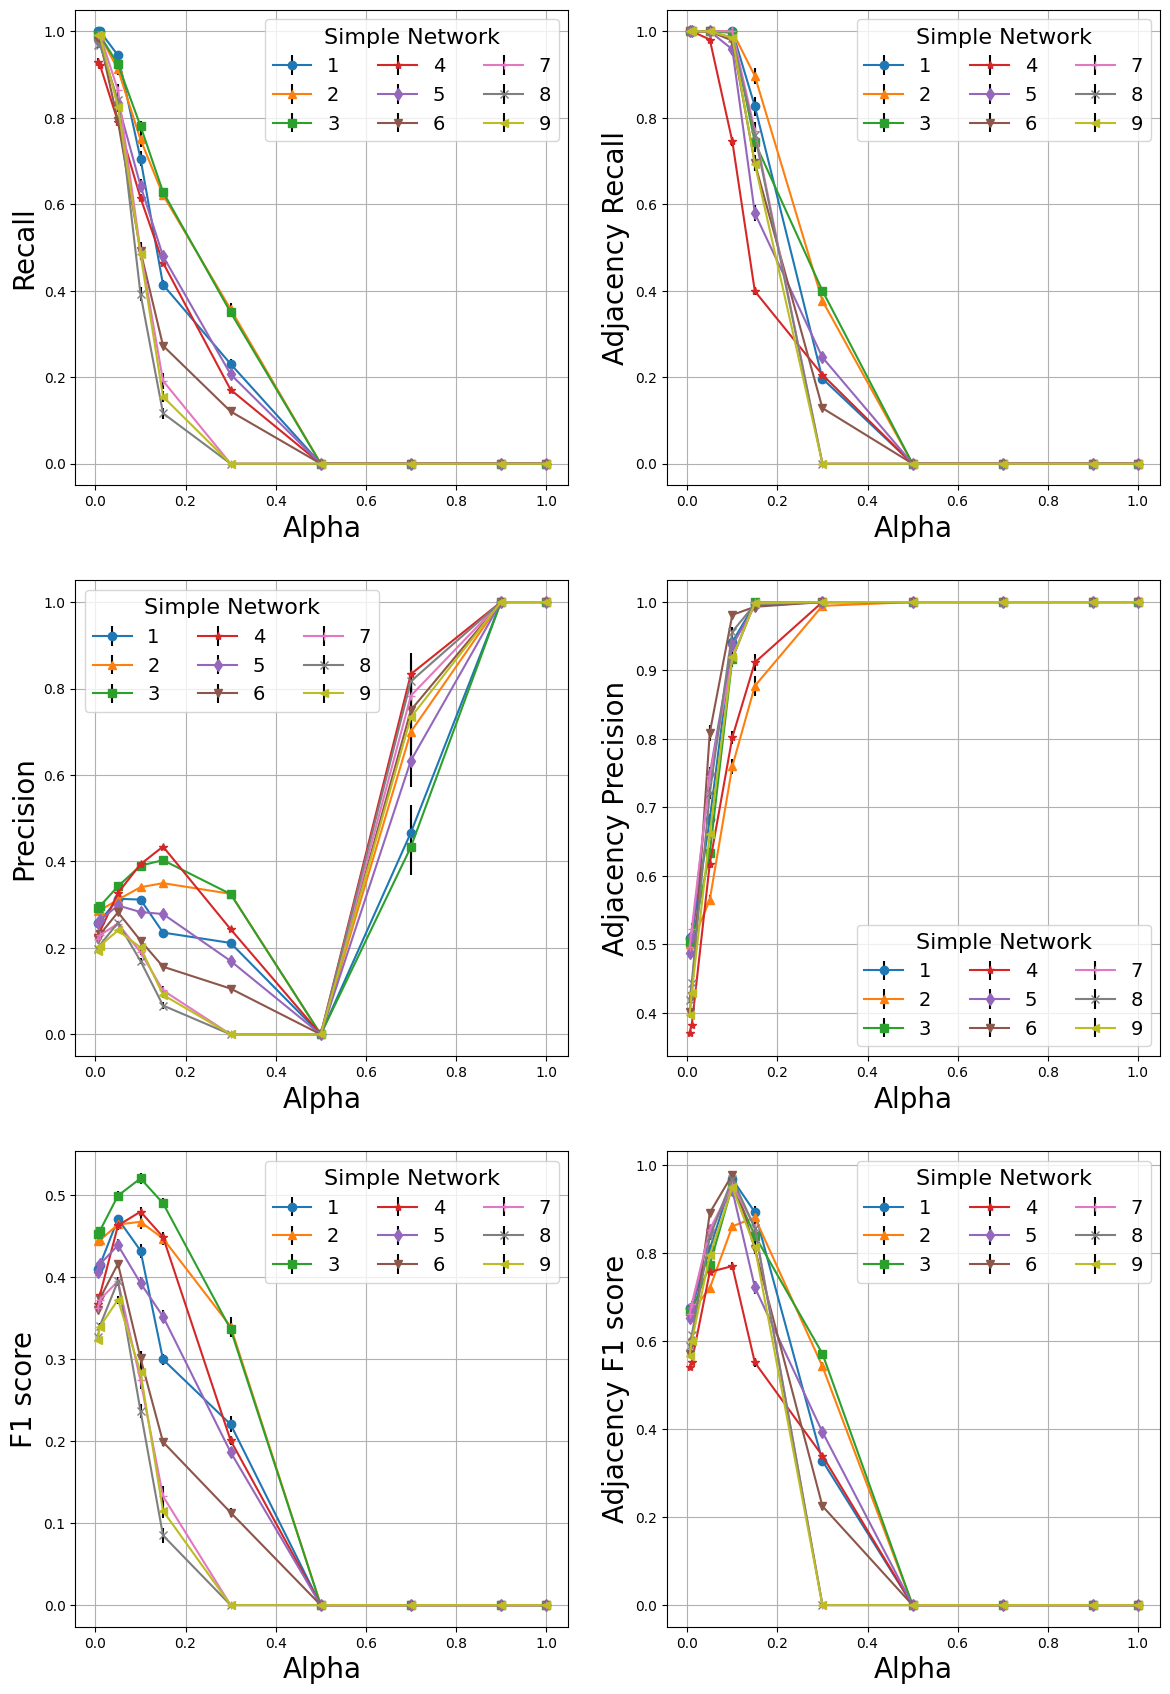

In [24]:
# Recall and Precision, and F1_score vs alpha for adjacency
varlingam_best_alpha_adj_mean = np.zeros((num_simple_networks,1))
varlingam_best_alpha_adj_median = np.zeros((num_simple_networks,1))
varlingam_best_alpha_ori_mean = np.zeros((num_simple_networks,1))
varlingam_best_alpha_ori_median = np.zeros((num_simple_networks,1))

plt.figure(figsize = (14, 21))

for n in range(0,num_simple_networks):
    varlingam_adj_recall_mean = np.zeros_like(alpha)
    varlingam_adj_recall_std = np.zeros_like(alpha)
    varlingam_adj_recall_median = np.zeros_like(alpha)

    varlingam_adj_precision_mean = np.zeros_like(alpha) 
    varlingam_adj_precision_std = np.zeros_like(alpha)
    varlingam_adj_precision_median = np.zeros_like(alpha) 

    varlingam_adj_F1_score_mean = np.zeros_like(alpha) 
    varlingam_adj_F1_score_std = np.zeros_like(alpha)
    varlingam_adj_F1_score_median = np.zeros_like(alpha) 

    varlingam_ori_recall_mean = np.zeros_like(alpha)
    varlingam_ori_recall_std = np.zeros_like(alpha)
    varlingam_ori_recall_median = np.zeros_like(alpha)

    varlingam_ori_precision_mean = np.zeros_like(alpha)
    varlingam_ori_precision_std = np.zeros_like(alpha)
    varlingam_ori_precision_median = np.zeros_like(alpha)

    varlingam_ori_F1_score_mean = np.zeros_like(alpha)
    varlingam_ori_F1_score_std =np.zeros_like(alpha)
    varlingam_ori_F1_score_median = np.zeros_like(alpha)

    for a in range(0,len(alpha)):

        varlingam_adj_recall_mean[a] = np.mean(np.array(varlingam_adj_Recall_all_rep[n])[:,a])
        varlingam_adj_recall_std[a] = np.std(np.array(varlingam_adj_Recall_all_rep[n])[:,a])
        varlingam_adj_recall_median[a] = np.median(np.array(varlingam_adj_Recall_all_rep[n])[:,a])

        varlingam_adj_precision_mean[a] = np.mean(np.array(varlingam_adj_Precision_all_rep[n])[:,a])
        varlingam_adj_precision_std[a] = np.std(np.array(varlingam_adj_Precision_all_rep[n])[:,a])
        varlingam_adj_precision_median[a] = np.median(np.array(varlingam_adj_Precision_all_rep[n])[:,a])

        varlingam_adj_F1_score_mean[a] = np.mean(np.array(varlingam_adj_F1_score_all_rep[n])[:,a])
        varlingam_adj_F1_score_std[a] = np.std(np.array(varlingam_adj_F1_score_all_rep[n])[:,a])
        varlingam_adj_F1_score_median[a] = np.median(np.array(varlingam_adj_F1_score_all_rep[n])[:,a])

        varlingam_ori_recall_mean[a] = np.mean(np.array(varlingam_ori_Recall_all_rep[n])[:,a])
        varlingam_ori_recall_std[a] = np.std(np.array(varlingam_ori_Recall_all_rep[n])[:,a])
        varlingam_ori_recall_median[a] = np.median(np.array(varlingam_ori_Recall_all_rep[n])[:,a])

        varlingam_ori_precision_mean[a] = np.mean(np.array(varlingam_ori_Precision_all_rep[n])[:,a])
        varlingam_ori_precision_std[a] = np.std(np.array(varlingam_ori_Precision_all_rep[n])[:,a])
        varlingam_ori_precision_median[a] = np.median(np.array(varlingam_ori_Precision_all_rep[n])[:,a])

        varlingam_ori_F1_score_mean[a] = np.mean(np.array(varlingam_ori_F1_score_all_rep[n])[:,a])
        varlingam_ori_F1_score_std[a] = np.std(np.array(varlingam_ori_F1_score_all_rep[n])[:,a])
        varlingam_ori_F1_score_median[a] = np.median(np.array(varlingam_ori_F1_score_all_rep[n])[:,a])

    varlingam_best_alpha_adj_mean[n] = alpha[np.argmax(varlingam_adj_F1_score_mean)]
    varlingam_best_alpha_adj_median[n] = alpha[np.argmax(varlingam_adj_F1_score_median)]
    varlingam_best_alpha_ori_mean[n] = alpha[np.argmax(varlingam_ori_F1_score_mean)]
    varlingam_best_alpha_ori_median[n] = alpha[np.argmax(varlingam_ori_F1_score_median)]

    plt.subplot(3,2,2)
    plt.errorbar(alpha, varlingam_adj_recall_mean, varlingam_adj_recall_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('Adjacency Recall', fontsize = 20)
    plt.grid()
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,1)
    plt.errorbar(alpha, varlingam_ori_recall_mean, varlingam_ori_recall_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('Recall', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)

    plt.subplot(3,2,4)
    plt.errorbar(alpha, varlingam_adj_precision_mean, varlingam_adj_precision_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('Adjacency Precision', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)

    plt.subplot(3,2,3)
    plt.errorbar(alpha, varlingam_ori_precision_mean, varlingam_ori_precision_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('Precision', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)

    plt.subplot(3,2,6)
    plt.errorbar(alpha, varlingam_adj_F1_score_mean, varlingam_adj_F1_score_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('Adjacency F1 score', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)

    plt.subplot(3,2,5)
    plt.errorbar(alpha, varlingam_ori_F1_score_mean, varlingam_ori_F1_score_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('F1 score', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)
plt.savefig('/home/fahimeh/Volitional_Control_Neurofeedback/Non-DecNef/codes/Causality_Analysis/Codes/resutls for paper/high_quality/supp/simple_nets_varlingam_precision_recall_f1_score.eps', bbox_inches = 'tight', format = 'eps')

## DGLearn

### Plot execution time for DGlearn for different networks and different values of alpha

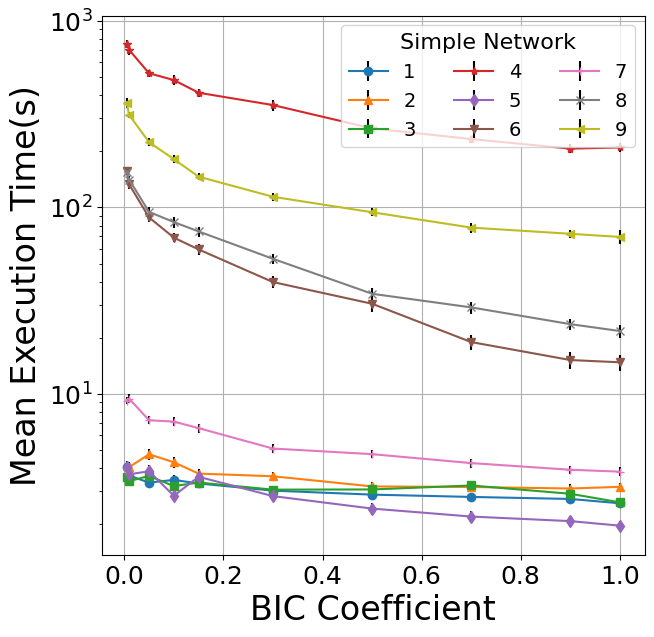

In [25]:
Dglearn_Mean_Exe_Time = np.zeros((num_simple_networks, len(bic_coef_all)))
Dglearn_std_Exe_Time = np.zeros((num_simple_networks, len(bic_coef_all)))
for n in range(0, num_simple_networks):
    for b in range(0, len(bic_coef_all)):
        Dglearn_Mean_Exe_Time[n,b] = np.mean(np.array(dglearn_simple_net_execution_time[n])[:,b])
        Dglearn_std_Exe_Time[n,b] = np.std(np.array(dglearn_simple_net_execution_time[n])[:,b])

markers = ['o-', '^-', 's-', '*-', 'd-', 'v-','+-','x-','<-']
plt.figure(figsize = (7,7))
for n in range(0, num_simple_networks):
    plt.errorbar(bic_coef_all, Dglearn_Mean_Exe_Time[n,:], Dglearn_std_Exe_Time[n,:]/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])

plt.xlabel('BIC Coefficient', fontsize = 24)
plt.ylabel('Mean Execution Time(s)', fontsize = 24)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.yscale('log')
plt.grid()

plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)

### DGLearn Performance

In [26]:
dglearn_adj_TPR_all_rep = [[['' for t in range(0, len(bic_coef_all))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
dglearn_adj_FPR_all_rep = [[['' for t in range(0, len(bic_coef_all))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
dglearn_adj_Recall_all_rep = [[['' for t in range(0, len(bic_coef_all))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
dglearn_adj_Precision_all_rep = [[['' for t in range(0, len(bic_coef_all))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
dglearn_adj_F1_score_all_rep = [[['' for t in range(0, len(bic_coef_all))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]

dglearn_ori_TPR_all_rep = [[['' for t in range(0, len(bic_coef_all))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
dglearn_ori_FPR_all_rep = [[['' for t in range(0, len(bic_coef_all))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
dglearn_ori_Recall_all_rep = [[['' for t in range(0, len(bic_coef_all))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
dglearn_ori_Precision_all_rep = [[['' for t in range(0, len(bic_coef_all))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]
dglearn_ori_F1_score_all_rep = [[['' for t in range(0, len(bic_coef_all))] for j in range(0,num_rep_simple_net)] for i in range(0,num_simple_networks )]

for n in range(0, num_simple_networks):
    for r in range(0,num_rep_simple_net):
        for b in range(0, len(bic_coef_all)):

            ground_truth = ground_truth_graph_matrix_all_networks[n]
            
            graph = np.array(dglearn_link_matrix_all_simple_net[n][r][b])

            adjacency_TPR, adjacency_FPR, adjacency_Recall, adjacency_Precision, adjacency_F1_score, orientation_TPR, orientation_FPR, orientation_Recall,orientation_Precision,orientation_F1_score = funcs.find_tpr_fpr_from_binary_matrix(ground_truth, graph)

            dglearn_adj_TPR_all_rep[n][r][b] = adjacency_TPR
            dglearn_adj_FPR_all_rep[n][r][b]  = adjacency_FPR
            dglearn_adj_Recall_all_rep[n][r][b]  = adjacency_Recall
            dglearn_adj_Precision_all_rep[n][r][b] = adjacency_Precision
            dglearn_adj_F1_score_all_rep[n][r][b]  = adjacency_F1_score

            dglearn_ori_TPR_all_rep[n][r][b]  = orientation_TPR
            dglearn_ori_FPR_all_rep [n][r][b] = orientation_FPR
            dglearn_ori_Recall_all_rep[n][r][b] = orientation_Recall
            dglearn_ori_Precision_all_rep[n][r][b]  = orientation_Precision
            dglearn_ori_F1_score_all_rep[n][r][b]  = orientation_F1_score

### Recall, Precision, and F1 score with Error Bars for different values of BIC coeffiecient

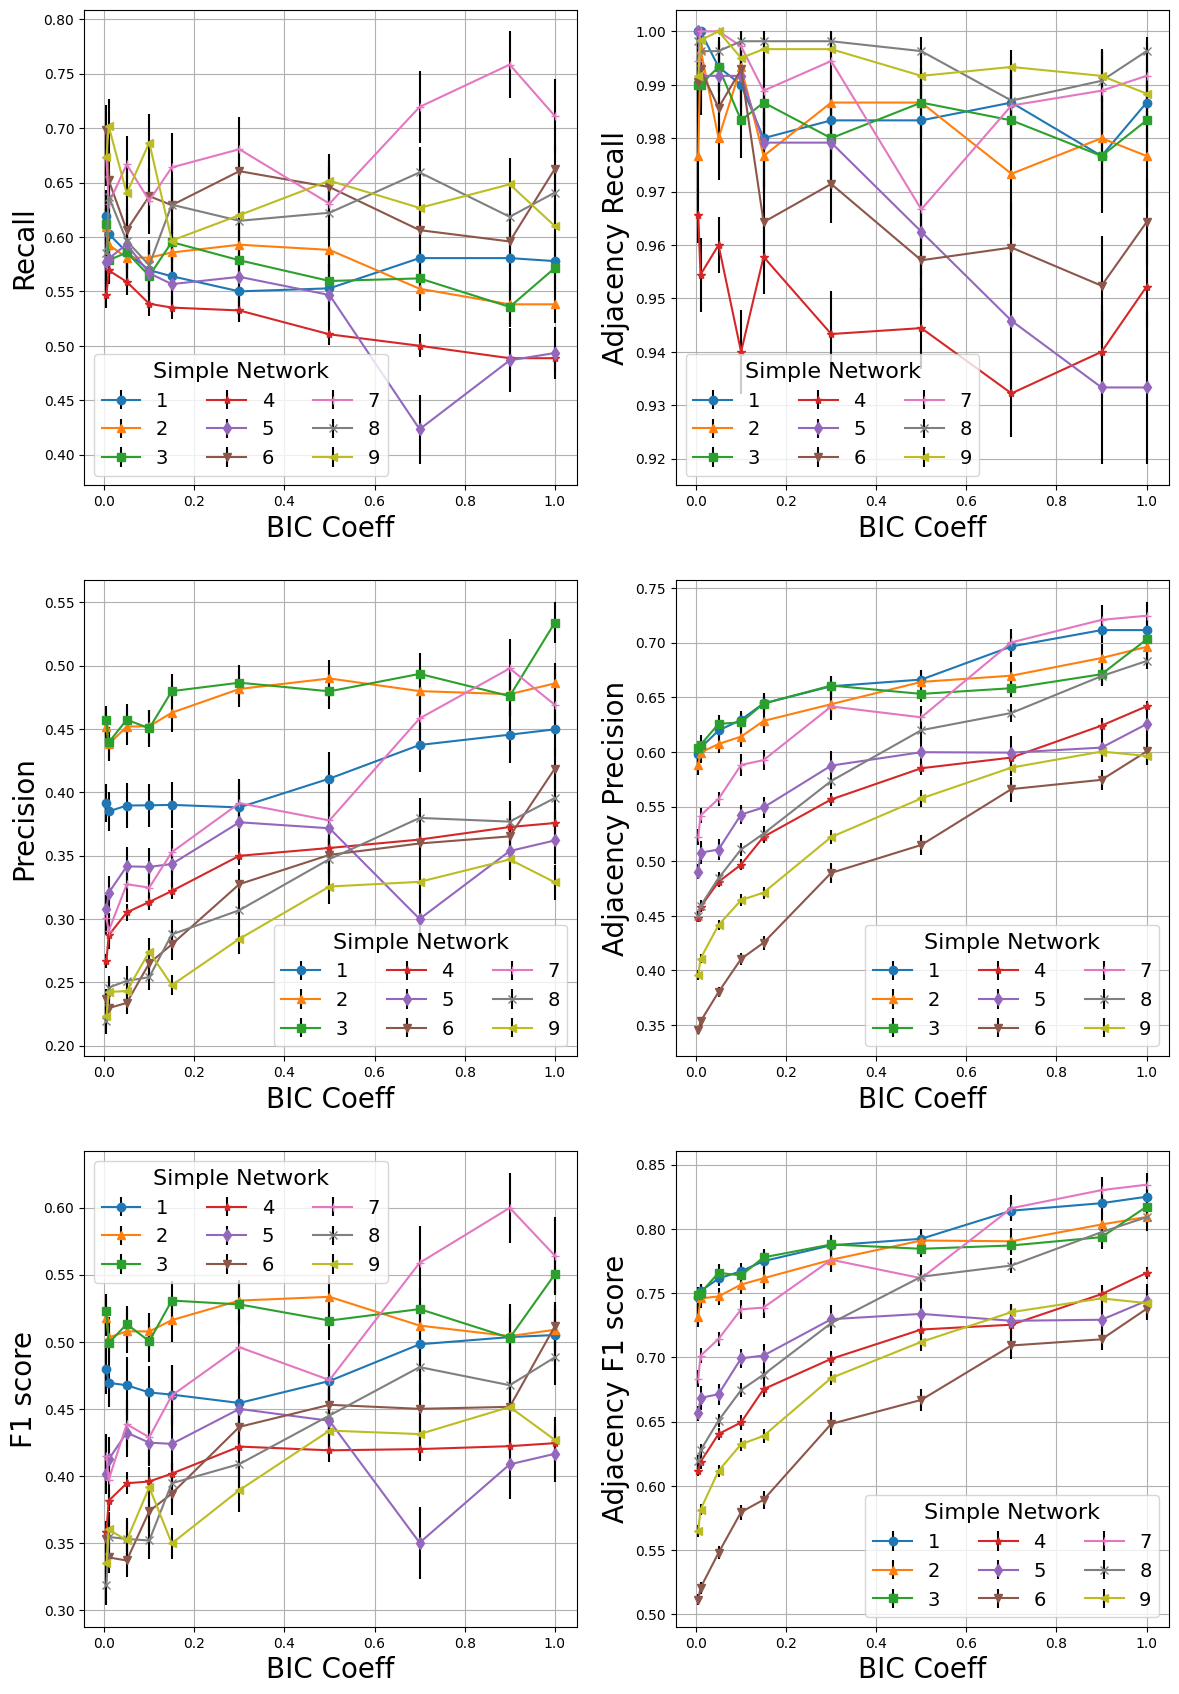

In [27]:
# Recall and Precision, and F1_score vs alpha for adjacency
dglearn_best_bic_score_adj_mean = np.zeros((num_simple_networks,1))
dglearn_best_bic_score_adj_median = np.zeros((num_simple_networks,1))
dglearn_best_bic_score_ori_mean = np.zeros((num_simple_networks,1))
dglearn_best_bic_score_ori_median = np.zeros((num_simple_networks,1))

plt.figure(figsize = (14, 21))

for n in range(0,num_simple_networks):
    dglearn_adj_recall_mean = np.zeros_like(bic_coef_all)
    dglearn_adj_recall_std = np.zeros_like(bic_coef_all)
    dglearn_adj_recall_median = np.zeros_like(bic_coef_all)


    dglearn_adj_precision_mean = np.zeros_like(bic_coef_all) 
    dglearn_adj_precision_std = np.zeros_like(bic_coef_all)
    dglearn_adj_precision_median = np.zeros_like(bic_coef_all) 


    dglearn_adj_F1_score_mean = np.zeros_like(bic_coef_all) 
    dglearn_adj_F1_score_std = np.zeros_like(bic_coef_all)
    dglearn_adj_F1_score_median = np.zeros_like(bic_coef_all) 


    dglearn_ori_recall_mean = np.zeros_like(bic_coef_all)
    dglearn_ori_recall_std = np.zeros_like(bic_coef_all)
    dglearn_ori_recall_median = np.zeros_like(bic_coef_all)


    dglearn_ori_precision_mean = np.zeros_like(bic_coef_all)
    dglearn_ori_precision_std = np.zeros_like(bic_coef_all)
    dglearn_ori_precision_median = np.zeros_like(bic_coef_all)


    dglearn_ori_F1_score_mean = np.zeros_like(bic_coef_all)
    dglearn_ori_F1_score_std =np.zeros_like(bic_coef_all)
    dglearn_ori_F1_score_median = np.zeros_like(bic_coef_all)



    for b in range(0,len(bic_coef_all)):

        dglearn_adj_recall_mean[b] = np.mean(np.array(dglearn_adj_Recall_all_rep[n])[:,b])
        dglearn_adj_recall_std[b] = np.std(np.array(dglearn_adj_Recall_all_rep[n])[:,b])
        dglearn_adj_recall_median[b] = np.median(np.array(dglearn_adj_Recall_all_rep[n])[:,b])


        dglearn_adj_precision_mean[b] = np.mean(np.array(dglearn_adj_Precision_all_rep[n])[:,b])
        dglearn_adj_precision_std[b] = np.std(np.array(dglearn_adj_Precision_all_rep[n])[:,b])
        dglearn_adj_precision_median[b] = np.median(np.array(dglearn_adj_Precision_all_rep[n])[:,b])


        dglearn_adj_F1_score_mean[b] = np.mean(np.array(dglearn_adj_F1_score_all_rep[n])[:,b])
        dglearn_adj_F1_score_std[b] = np.std(np.array(dglearn_adj_F1_score_all_rep[n])[:,b])
        dglearn_adj_F1_score_median[b] = np.median(np.array(dglearn_adj_F1_score_all_rep[n])[:,b])


        dglearn_ori_recall_mean[b] = np.mean(np.array(dglearn_ori_Recall_all_rep[n])[:,b])
        dglearn_ori_recall_std[b] = np.std(np.array(dglearn_ori_Recall_all_rep[n])[:,b])
        dglearn_ori_recall_median[b] = np.median(np.array(dglearn_ori_Recall_all_rep[n])[:,b])


        dglearn_ori_precision_mean[b] = np.mean(np.array(dglearn_ori_Precision_all_rep[n])[:,b])
        dglearn_ori_precision_std[b] = np.std(np.array(dglearn_ori_Precision_all_rep[n])[:,b])
        dglearn_ori_precision_median[b] = np.median(np.array(dglearn_ori_Precision_all_rep[n])[:,b])


        dglearn_ori_F1_score_mean[b] = np.mean(np.array(dglearn_ori_F1_score_all_rep[n])[:,b])
        dglearn_ori_F1_score_std[b] = np.std(np.array(dglearn_ori_F1_score_all_rep[n])[:,b])
        dglearn_ori_F1_score_median[b] = np.median(np.array(dglearn_ori_F1_score_all_rep[n])[:,b])


    dglearn_best_bic_score_adj_mean[n] = bic_coef_all[np.argmax(dglearn_adj_F1_score_mean)]
    dglearn_best_bic_score_adj_median[n] = bic_coef_all[np.argmax(dglearn_adj_F1_score_median)]
    dglearn_best_bic_score_ori_mean[n] = bic_coef_all[np.argmax(dglearn_ori_F1_score_mean)]
    dglearn_best_bic_score_ori_median[n] = bic_coef_all[np.argmax(dglearn_ori_F1_score_median)]

    plt.subplot(3,2,2)
    plt.errorbar(bic_coef_all, dglearn_adj_recall_mean, dglearn_adj_recall_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('BIC Coeff', fontsize = 20)
    plt.ylabel('Adjacency Recall', fontsize = 20)
    plt.grid()
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,1)
    plt.errorbar(bic_coef_all, dglearn_ori_recall_mean, dglearn_ori_recall_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('BIC Coeff', fontsize = 20)
    plt.ylabel('Recall', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,4)
    plt.errorbar(bic_coef_all, dglearn_adj_precision_mean, dglearn_adj_precision_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('BIC Coeff', fontsize = 20)
    plt.ylabel('Adjacency Precision', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,3)
    plt.errorbar(bic_coef_all, dglearn_ori_precision_mean, dglearn_ori_precision_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('BIC Coeff', fontsize = 20)
    plt.ylabel('Precision', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,6)
    plt.errorbar(bic_coef_all, dglearn_adj_F1_score_mean, dglearn_adj_F1_score_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('BIC Coeff', fontsize = 20)
    plt.ylabel('Adjacency F1 score', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,5)
    plt.errorbar(bic_coef_all, dglearn_ori_F1_score_mean, dglearn_ori_F1_score_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('BIC Coeff', fontsize = 20)
    plt.ylabel('F1 score', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)

## MVGC

### Time Execution

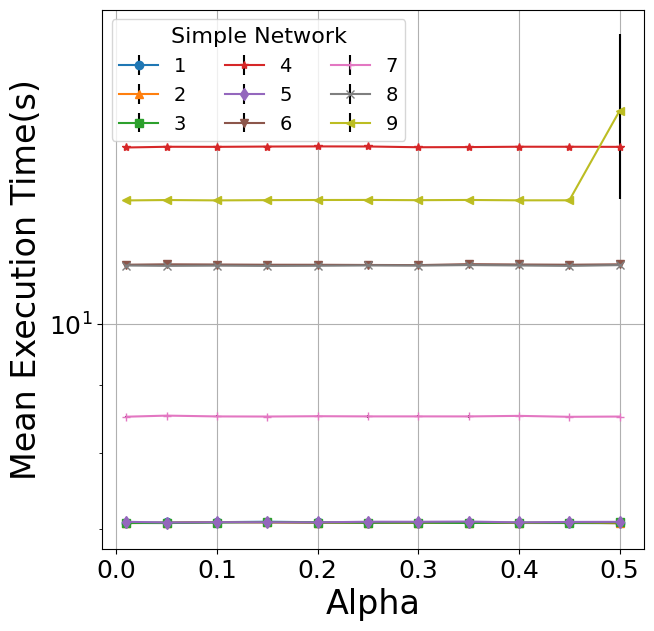

In [28]:
MVGC_Mean_Exe_Time = np.zeros((num_simple_networks, len(mvgc_alpha)))
MVGC_std_Exe_Time = np.zeros((num_simple_networks, len(mvgc_alpha)))
for n in range(0, num_simple_networks):
    for a in range(0, len(mvgc_alpha)):
        MVGC_Mean_Exe_Time[n,a] = np.mean(np.array(mvgc_simple_net_execution_time[n])[:,a])
        MVGC_std_Exe_Time[n,a] = np.std(np.array(mvgc_simple_net_execution_time[n])[:,a])

markers = ['o-', '^-', 's-', '*-', 'd-', 'v-','+-','x-','<-']
plt.figure(figsize = (7,7))
for n in range(0, num_simple_networks):
    plt.errorbar(mvgc_alpha, MVGC_Mean_Exe_Time[n,:], MVGC_std_Exe_Time[n,:]/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])

plt.yscale('log')
plt.xlabel('Alpha', fontsize = 24)
plt.ylabel('Mean Execution Time(s)', fontsize = 24)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.grid()

plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)

### MVGC Performance

In [29]:
mvgc_adj_TPR_all_rep = [[['' for t in range(0, len(mvgc_alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_rep_simple_net )]
mvgc_adj_FPR_all_rep = [[['' for t in range(0, len(mvgc_alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_rep_simple_net )]
mvgc_adj_Recall_all_rep = [[['' for t in range(0, len(mvgc_alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_rep_simple_net )]
mvgc_adj_Precision_all_rep = [[['' for t in range(0, len(mvgc_alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_rep_simple_net )]
mvgc_adj_F1_score_all_rep = [[['' for t in range(0, len(mvgc_alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_rep_simple_net )]

mvgc_ori_TPR_all_rep = [[['' for t in range(0, len(mvgc_alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_rep_simple_net )]
mvgc_ori_FPR_all_rep = [[['' for t in range(0, len(mvgc_alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_rep_simple_net )]
mvgc_ori_Recall_all_rep = [[['' for t in range(0, len(mvgc_alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_rep_simple_net )]
mvgc_ori_Precision_all_rep = [[['' for t in range(0, len(mvgc_alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_rep_simple_net )]
mvgc_ori_F1_score_all_rep = [[['' for t in range(0, len(mvgc_alpha))] for j in range(0,num_rep_simple_net)] for i in range(0,num_rep_simple_net )]


for n in range(0,num_simple_networks):
    for r in range(0, num_rep_simple_net):
        for a in range(0, len(mvgc_alpha)):
           
                true_graph_matrix = np.array(ground_truth_graph_matrix_all_networks[n])
                estimated_graph_matrix = np.array(mvgc_link_matrix_all_simple_net[n][r][a])-1
                adjacency_TPR, adjacency_FPR, adjacency_Recall, adjacency_Precision, adjacency_F1_score, orientation_TPR, orientation_FPR, orientation_Recall,orientation_Precision,orientation_F1_score = funcs.find_tpr_fpr_from_binary_matrix(true_graph_matrix, estimated_graph_matrix)

                mvgc_adj_TPR_all_rep[n][r][a] = adjacency_TPR
                mvgc_adj_FPR_all_rep[n][r][a] = adjacency_FPR
                mvgc_adj_Recall_all_rep[n][r][a] = adjacency_Recall
                mvgc_adj_Precision_all_rep[n][r][a] = adjacency_Precision
                mvgc_adj_F1_score_all_rep[n][r][a] = adjacency_F1_score

                mvgc_ori_TPR_all_rep[n][r][a] = orientation_TPR
                mvgc_ori_FPR_all_rep[n][r][a] = orientation_FPR
                mvgc_ori_Recall_all_rep[n][r][a] = orientation_Recall
                mvgc_ori_Precision_all_rep[n][r][a] = orientation_Precision
                mvgc_ori_F1_score_all_rep[n][r][a] = orientation_F1_score

### Precision, Recall, F1 scores

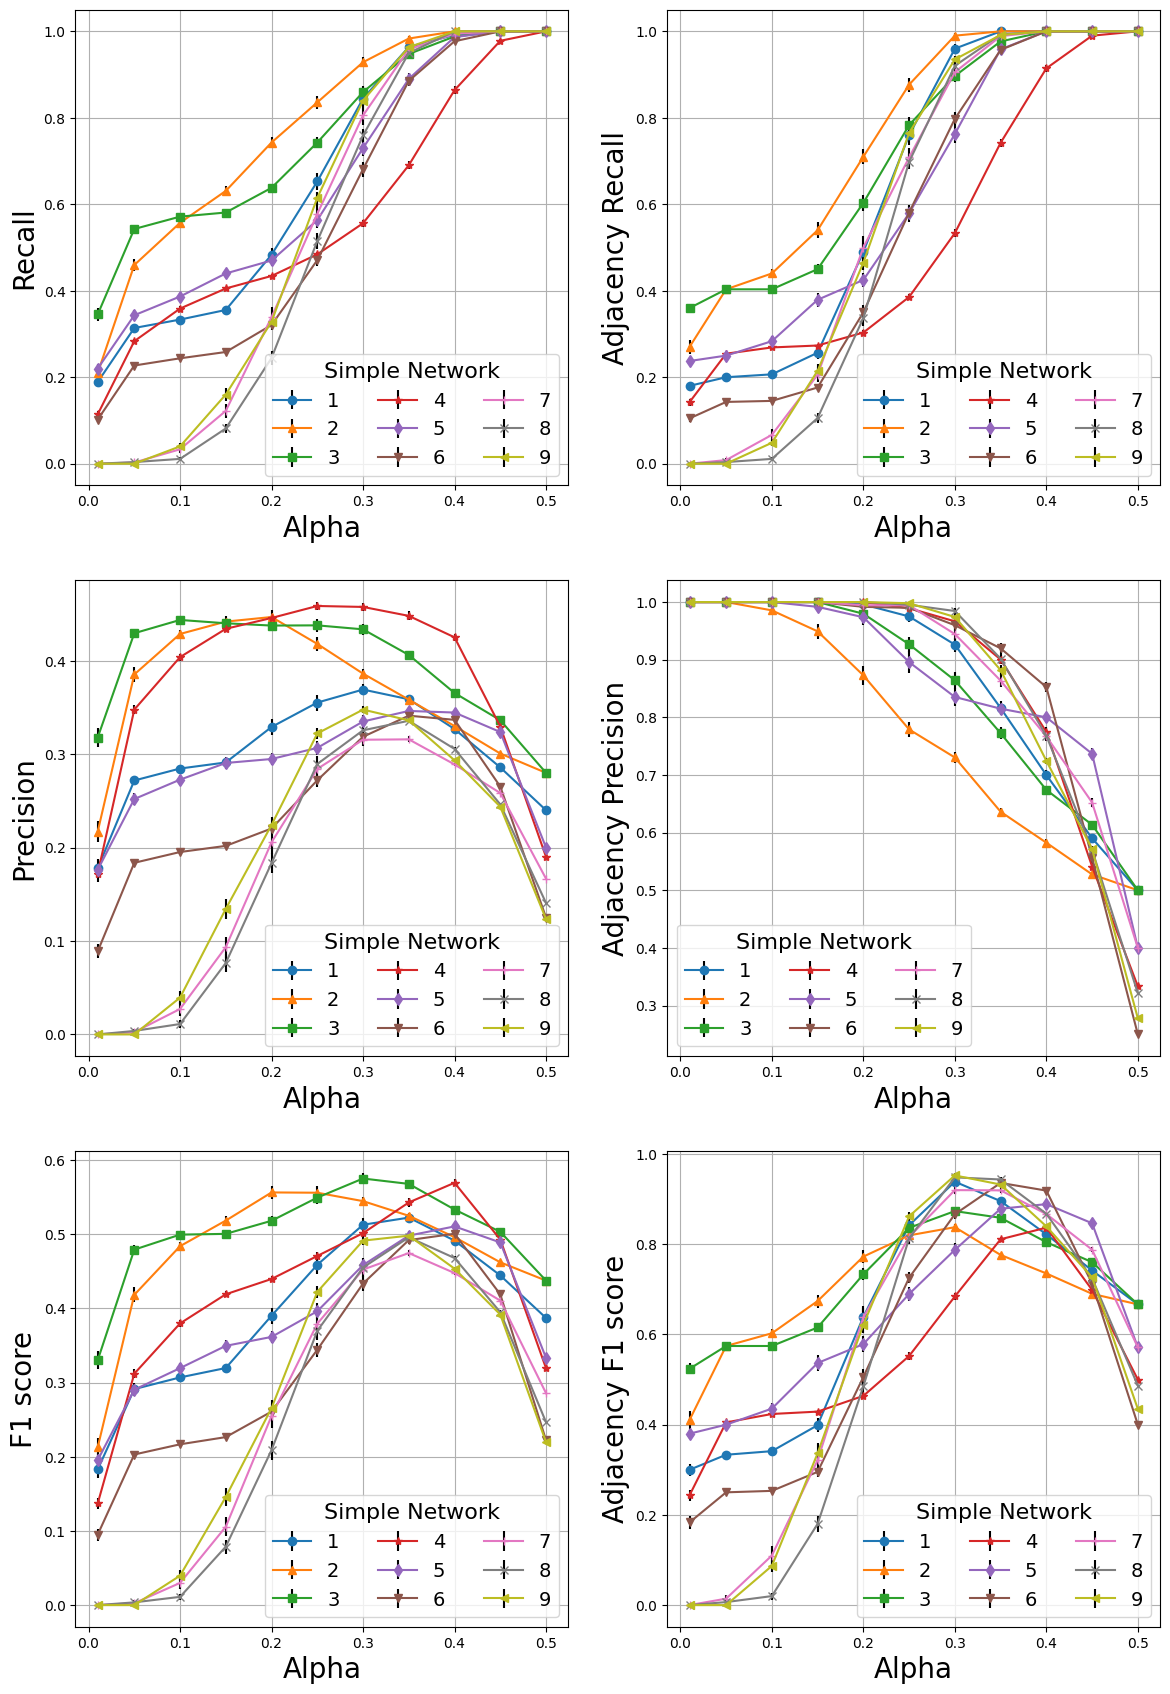

In [30]:
# Recall and Precision, and F1_score vs alpha for adjacency
plt.figure(figsize = (14, 21))

mvgc_best_alpha_adj_mean = np.zeros((num_simple_networks,1))
mvgc_best_alpha_adj_median = np.zeros((num_simple_networks,1))
mvgc_best_alpha_ori_mean = np.zeros((num_simple_networks,1))
mvgc_best_alpha_ori_median = np.zeros((num_simple_networks,1))

for n in range(0, num_simple_networks):
    
    mvgc_adj_recall_mean = np.zeros_like(mvgc_alpha)
    mvgc_adj_recall_std = np.zeros_like(mvgc_alpha)
    mvgc_adj_recall_median = np.zeros_like(mvgc_alpha)

    mvgc_adj_precision_mean = np.zeros_like(mvgc_alpha) 
    mvgc_adj_precision_std = np.zeros_like(mvgc_alpha)
    mvgc_adj_precision_median = np.zeros_like(mvgc_alpha) 

    mvgc_adj_F1_score_mean = np.zeros_like(mvgc_alpha) 
    mvgc_adj_F1_score_std = np.zeros_like(mvgc_alpha)
    mvgc_adj_F1_score_median = np.zeros_like(mvgc_alpha) 

    mvgc_ori_recall_mean = np.zeros_like(mvgc_alpha)
    mvgc_ori_recall_std = np.zeros_like(mvgc_alpha)
    mvgc_ori_recall_median = np.zeros_like(mvgc_alpha)

    mvgc_ori_precision_mean = np.zeros_like(mvgc_alpha)
    mvgc_ori_precision_std = np.zeros_like(mvgc_alpha)
    mvgc_ori_precision_median = np.zeros_like(mvgc_alpha)

    mvgc_ori_F1_score_mean = np.zeros_like(mvgc_alpha)
    mvgc_ori_F1_score_std = np.zeros_like(mvgc_alpha)
    mvgc_ori_F1_score_median = np.zeros_like(mvgc_alpha)

    for a in range(0,len(mvgc_alpha)):

        mvgc_adj_recall_mean[a] = np.mean(np.array(mvgc_adj_Recall_all_rep[n])[:,a])
        mvgc_adj_recall_std[a] = np.std(np.array(mvgc_adj_Recall_all_rep[n])[:,a])
        mvgc_adj_recall_median[a] = np.median(np.array(mvgc_adj_Recall_all_rep[n])[:,a])

        mvgc_adj_precision_mean[a] = np.mean(np.array(mvgc_adj_Precision_all_rep[n])[:,a])
        mvgc_adj_precision_std[a] = np.std(np.array(mvgc_adj_Precision_all_rep[n])[:,a])
        mvgc_adj_precision_median[a] = np.median(np.array(mvgc_adj_Precision_all_rep[n])[:,a])

        mvgc_adj_F1_score_mean[a] = np.mean(np.array(mvgc_adj_F1_score_all_rep[n])[:,a])
        mvgc_adj_F1_score_std[a] = np.std(np.array(mvgc_adj_F1_score_all_rep[n])[:,a])
        mvgc_adj_F1_score_median[a] = np.median(np.array(mvgc_adj_F1_score_all_rep[n])[:,a])

        mvgc_ori_recall_mean[a] = np.mean(np.array(mvgc_ori_Recall_all_rep[n])[:,a])
        mvgc_ori_recall_std[a] = np.std(np.array(mvgc_ori_Recall_all_rep[n])[:,a])
        mvgc_ori_recall_median[a] = np.median(np.array(mvgc_ori_Recall_all_rep[n])[:,a])

        mvgc_ori_precision_mean[a] = np.mean(np.array(mvgc_ori_Precision_all_rep[n])[:,a])
        mvgc_ori_precision_std[a] = np.std(np.array(mvgc_ori_Precision_all_rep[n])[:,a])
        mvgc_ori_precision_median[a] = np.median(np.array(mvgc_ori_Precision_all_rep[n])[:,a])

        mvgc_ori_F1_score_mean[a] = np.mean(np.array(mvgc_ori_F1_score_all_rep[n])[:,a])
        mvgc_ori_F1_score_std[a] = np.std(np.array(mvgc_ori_F1_score_all_rep[n])[:,a])
        mvgc_ori_F1_score_median[a] = np.median(np.array(mvgc_ori_F1_score_all_rep[n])[:,a])

    mvgc_best_alpha_adj_mean[n] = mvgc_alpha[np.argmax(mvgc_adj_F1_score_mean)]
    mvgc_best_alpha_adj_median[n] = mvgc_alpha[np.argmax(mvgc_adj_F1_score_median)]
    mvgc_best_alpha_ori_mean[n] = mvgc_alpha[np.argmax(mvgc_ori_F1_score_mean)]
    mvgc_best_alpha_ori_median[n] = mvgc_alpha[np.argmax(mvgc_ori_F1_score_median)]

    plt.subplot(3,2,2)
    plt.errorbar(mvgc_alpha, mvgc_adj_recall_mean, mvgc_adj_recall_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('Adjacency Recall', fontsize = 20)
    plt.grid()
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,1)
    plt.errorbar(mvgc_alpha, mvgc_ori_recall_mean, mvgc_ori_recall_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('Recall', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,4)
    plt.errorbar(mvgc_alpha, mvgc_adj_precision_mean, mvgc_adj_precision_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('Adjacency Precision', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,3)
    plt.errorbar(mvgc_alpha, mvgc_ori_precision_mean, mvgc_ori_precision_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('Precision', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,6)
    plt.errorbar(mvgc_alpha, mvgc_adj_F1_score_mean, mvgc_adj_F1_score_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('Adjacency F1 score', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


    plt.subplot(3,2,5)
    plt.errorbar(mvgc_alpha, mvgc_ori_F1_score_mean, mvgc_ori_F1_score_std/np.sqrt(num_rep_simple_net), ecolor = 'black', fmt = markers[n])
    plt.xlabel('Alpha', fontsize = 20)
    plt.ylabel('F1 score', fontsize = 20)
    plt.grid(visible = True)
    plt.legend(np.arange(1, num_simple_networks+1), fontsize = 14, loc = 'best', ncol = 3, title = 'Simple Network', title_fontsize = 16)


## Comparison

### Execution Time of All the Methods

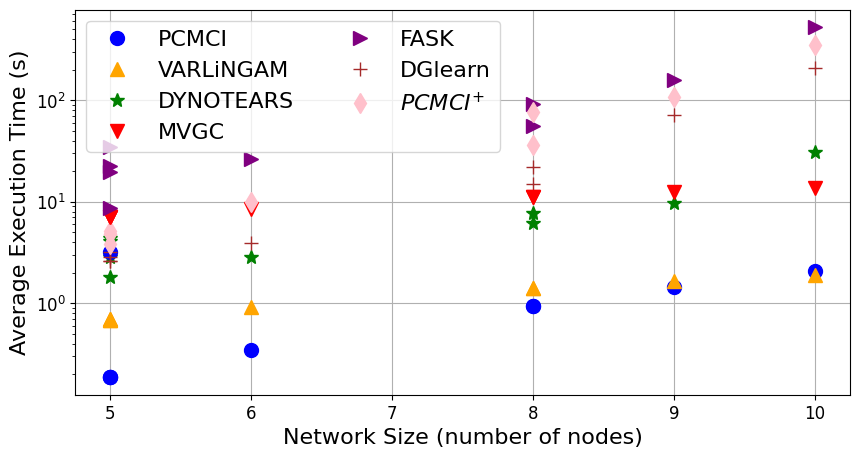

In [31]:
plt.figure(figsize = (10,5))

for n in range(0,num_simple_networks):
    plt.plot(net_size_all[n], PCMCI_Mean_Exe_Time[n,np.where(alpha_level_pcmci == pcmci_best_alpha_ori_mean[n][0])[0][0]], 'o', markersize = 10, color = 'blue')
    plt.plot(net_size_all[n], Varlingam_Mean_Exe_Time[n,np.where(alpha == varlingam_best_alpha_ori_mean[n][0])[0][0]], '^', markersize = 10, color = 'orange')
    plt.plot(net_size_all[n], Dynotears_Mean_Exe_Time[n,np.where(alpha_dynotears == dynotears_best_alpha_ori_mean[n][0])[0][0]], '*', markersize = 10, color = 'green')
    plt.plot(net_size_all[n], MVGC_Mean_Exe_Time[n,np.where(mvgc_alpha == mvgc_best_alpha_ori_mean[n][0])[0][0]], 'v', markersize = 10 , color = 'red')
    plt.plot(net_size_all[n], FASK_Mean_Exe_Time[n,np.where(alpha == fask_best_alpha_ori_mean[n][0])[0][0]], '>', markersize = 10 , color = 'purple')
    plt.plot(net_size_all[n], Dglearn_Mean_Exe_Time[n,np.where(bic_coef_all == dglearn_best_bic_score_ori_mean[n][0])[0][0]], '+', markersize = 10, color = 'brown')
    plt.plot(net_size_all[n], PCMCIplus_Mean_Exe_Time[n,np.where(pc_alpha_pcmciplus == pcmciplus_best_alpha_ori_mean[n][0])[0][0]], 'd', markersize = 10, color = 'pink')

    plt.yscale('log')
    plt.xlabel('Network Size (number of nodes)', fontsize = 16 )
    plt.ylabel('Average Execution Time (s)', fontsize = 16)
    plt.grid()

    plt.legend(['PCMCI','VARLiNGAM','DYNOTEARS','MVGC','FASK', 'DGlearn','$PCMCI^{+}$'], fontsize = 16, ncols = 2, loc = 'best')
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)


### Distribution of F1 scores at best hyperparameter value (for each network)

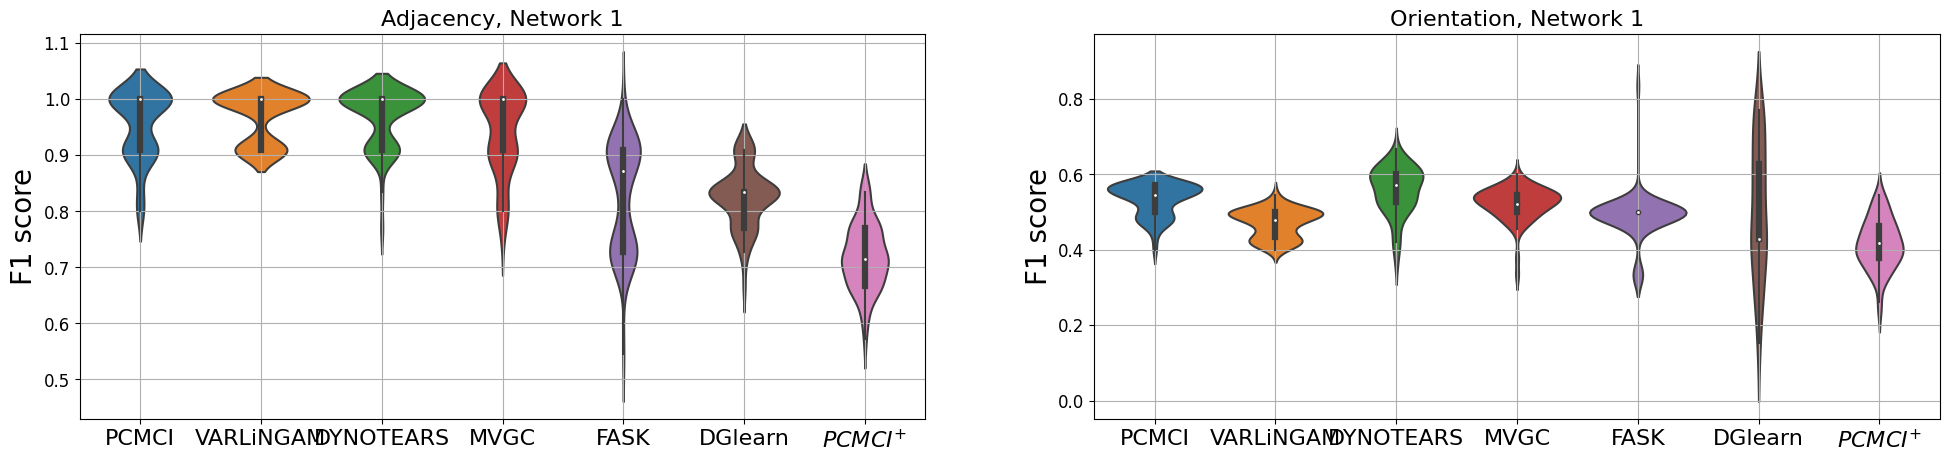

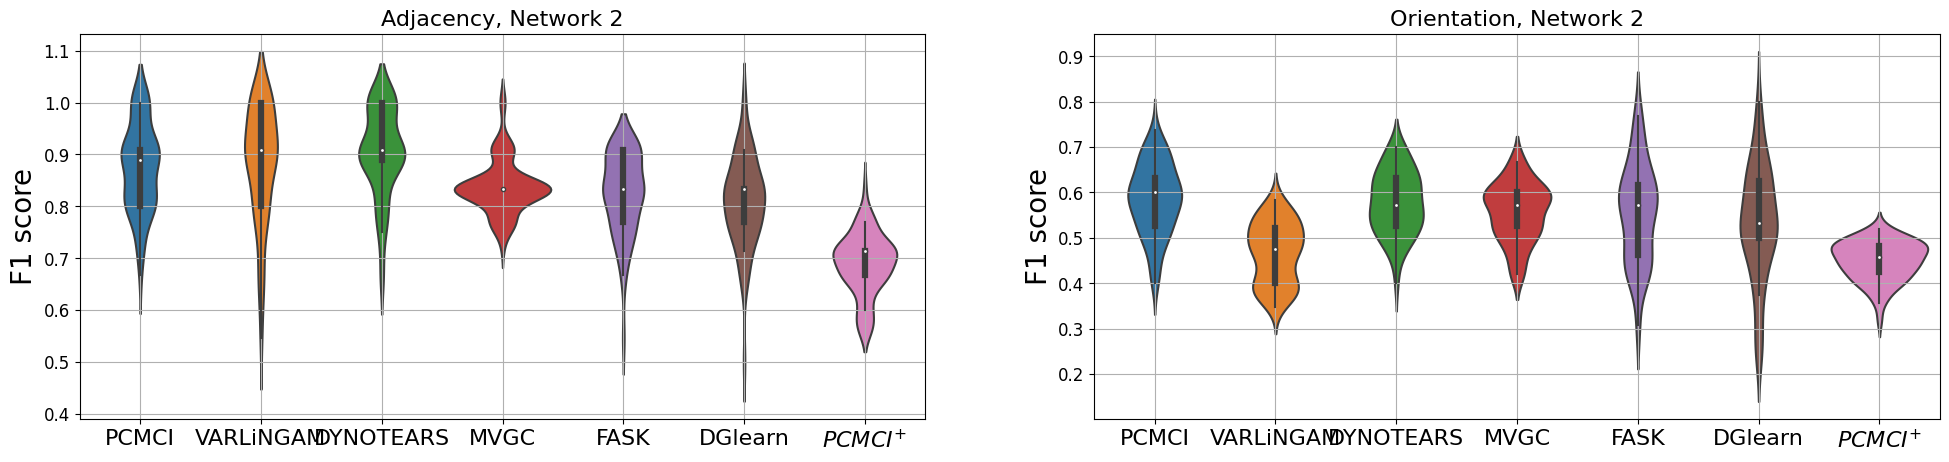

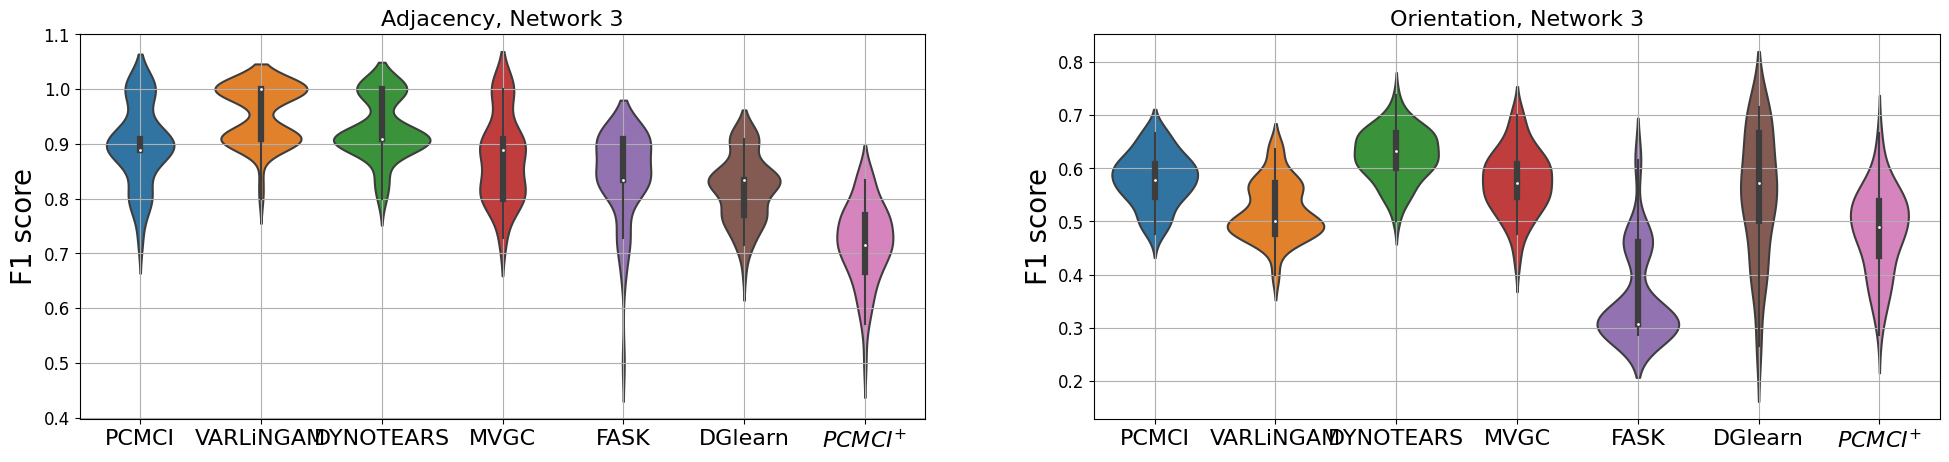

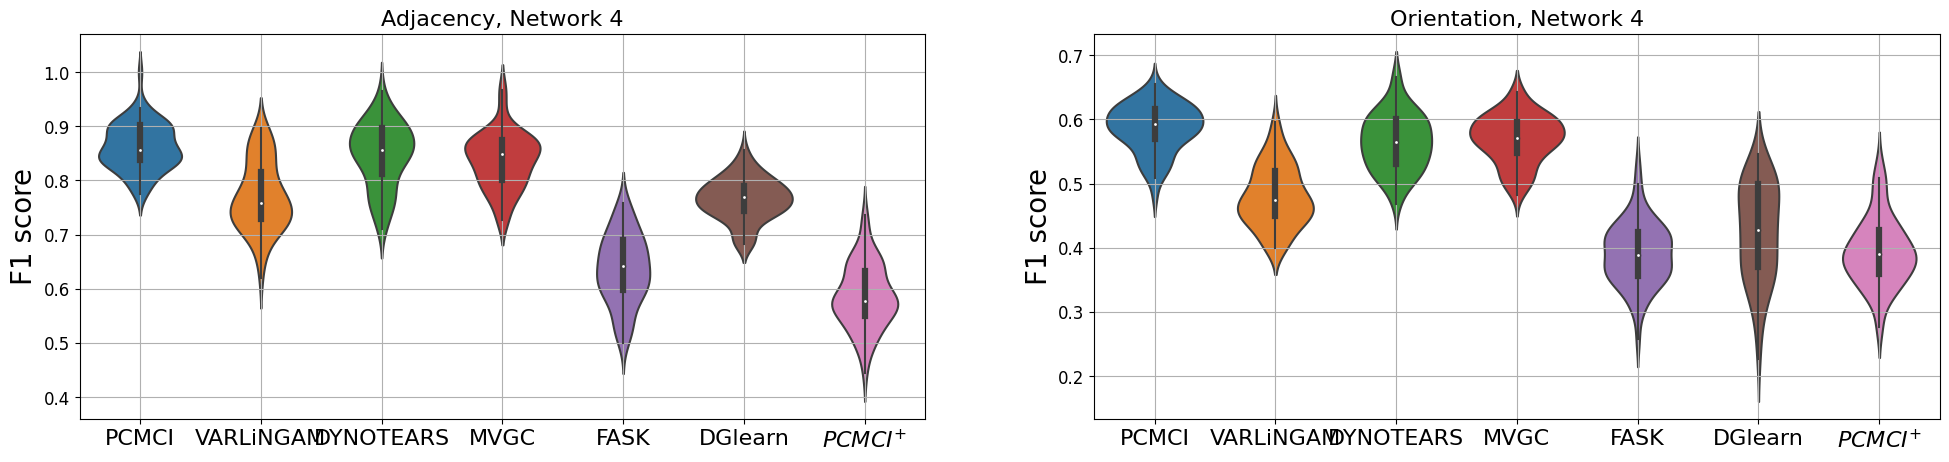

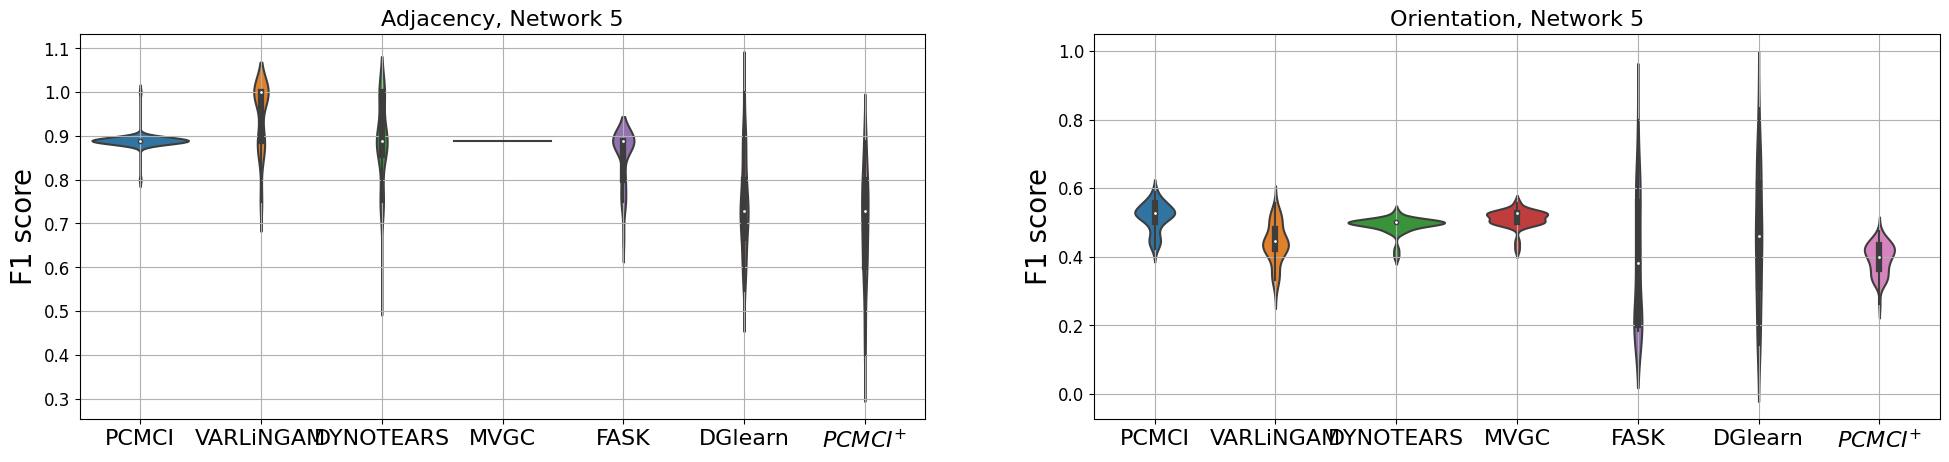

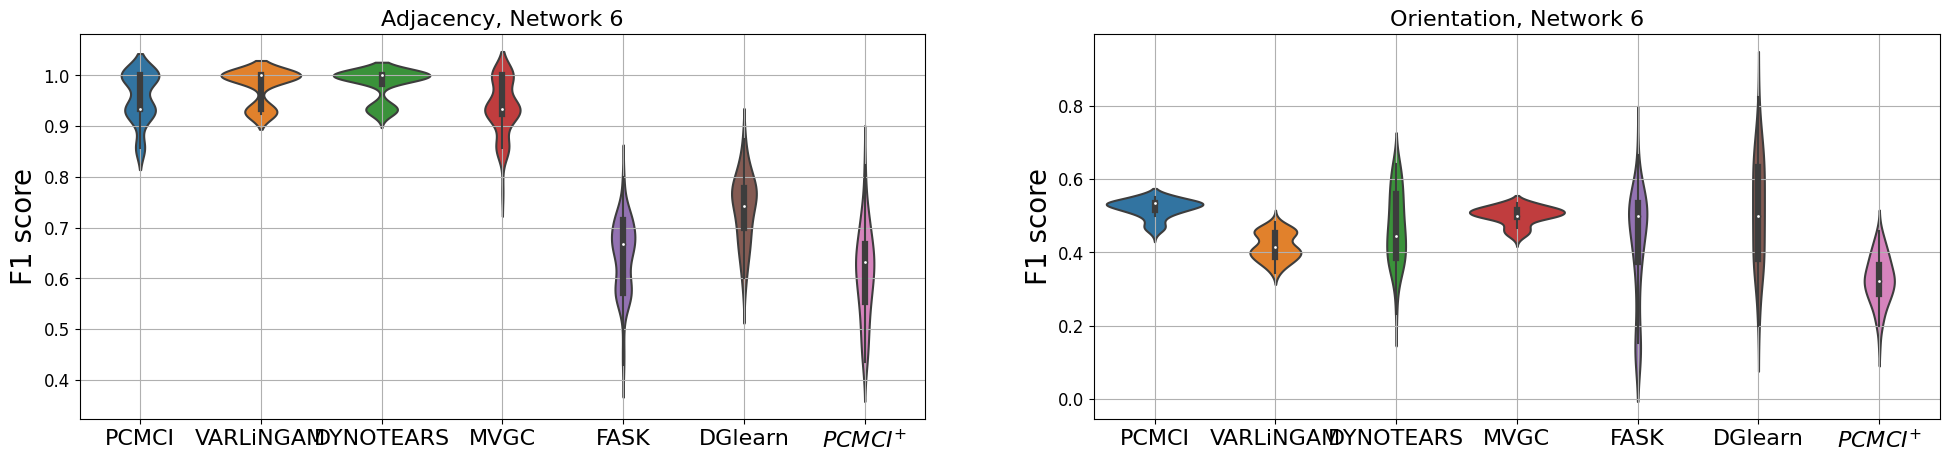

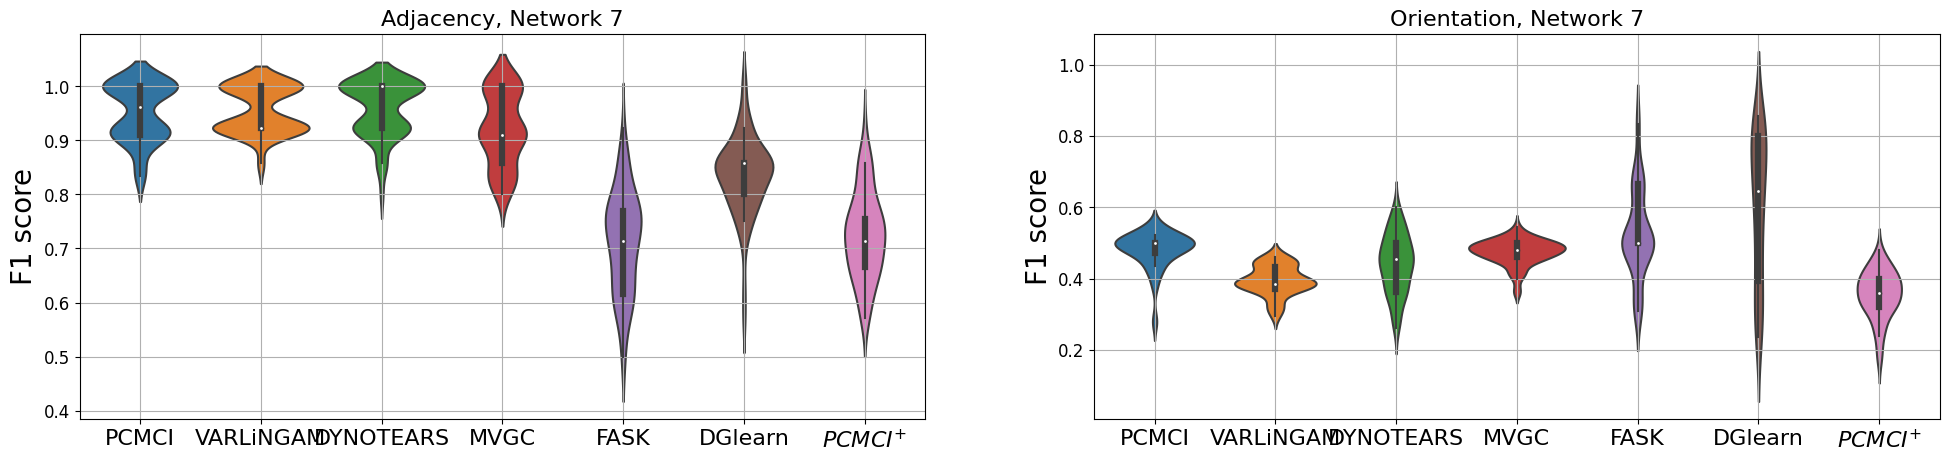

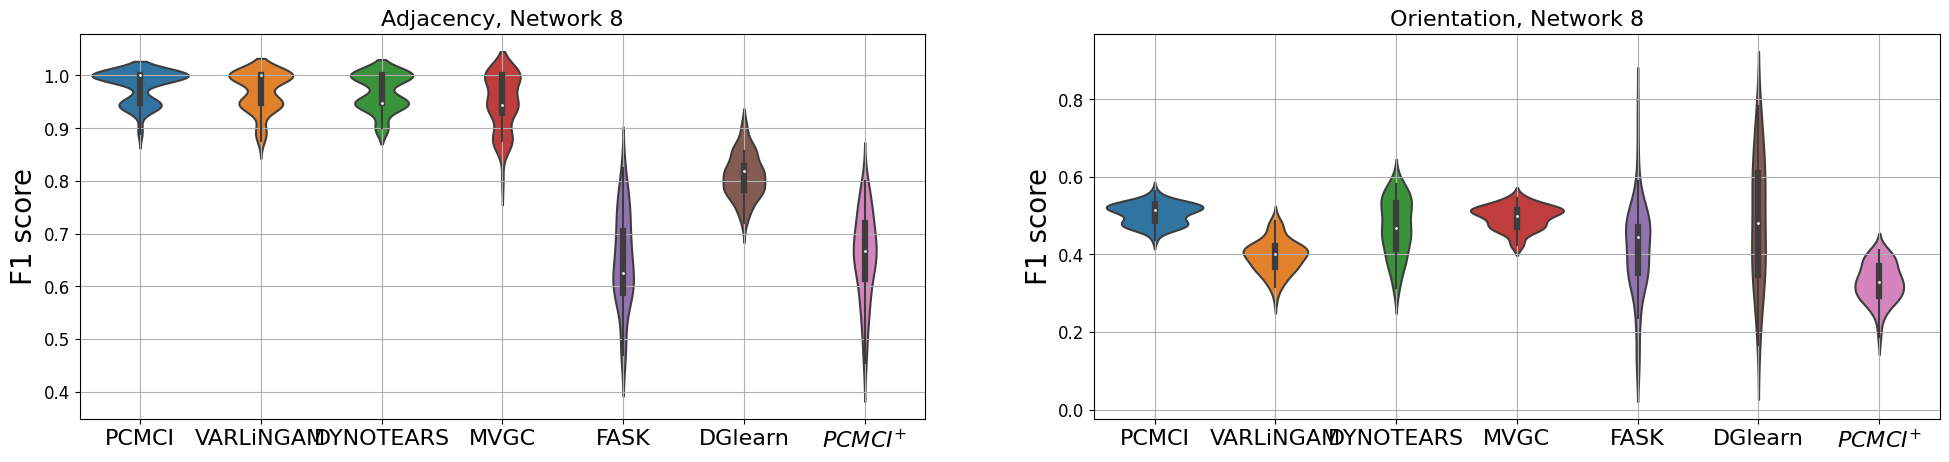

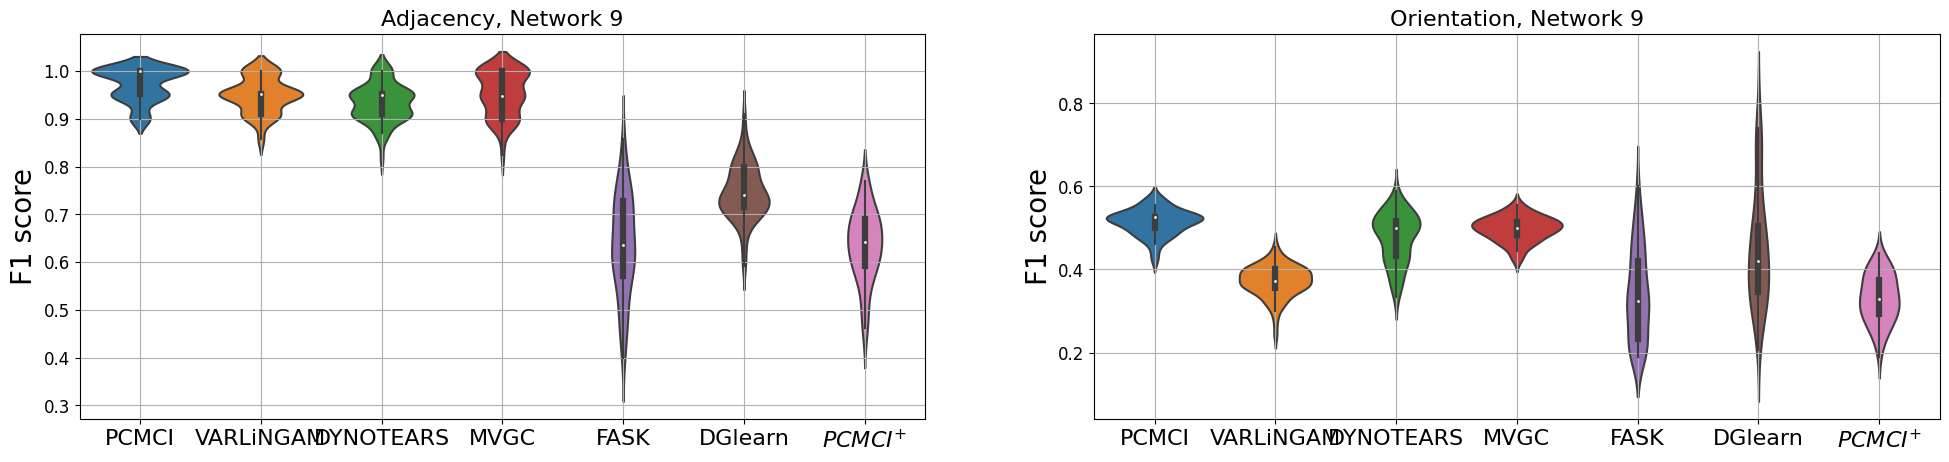

In [32]:

labels = ['PCMCI','VARLiNGAM','DYNOTEARS','MVGC','FASK', 'DGlearn','$PCMCI^{+}$']

for n in range(0,num_simple_networks):
    
    plt.figure(figsize = (24,5))

    adj_all_methods_F1_score_dist  = []
    ax1= plt.subplot(1,2,1)
    adj_all_methods_F1_score_dist. append(np.array(pcmci_adj_F1_score_all_rep[n])[:,np.where(alpha_level_pcmci == pcmci_best_alpha_adj_mean[n][0])[0][0]])
    adj_all_methods_F1_score_dist. append(np.array(varlingam_adj_F1_score_all_rep[n])[:,np.where(alpha == varlingam_best_alpha_adj_mean[n][0])[0][0]])
    adj_all_methods_F1_score_dist. append(np.array(dynotears_adj_F1_score_all_rep[n])[:,np.where(alpha_dynotears == dynotears_best_alpha_adj_mean[n][0])[0][0]])
    adj_all_methods_F1_score_dist. append(np.array(mvgc_adj_F1_score_all_rep[n])[:,np.where(mvgc_alpha == mvgc_best_alpha_adj_mean[n][0])[0][0]])
    adj_all_methods_F1_score_dist. append(np.array(fask_adj_F1_score_all_rep[n])[:,np.where(alpha == fask_best_alpha_adj_mean[n][0])[0][0]])
    adj_all_methods_F1_score_dist. append(np.array(dglearn_adj_F1_score_all_rep[n])[:,np.where(bic_coef_all == dglearn_best_bic_score_adj_mean[n][0])[0][0]])
    adj_all_methods_F1_score_dist. append(np.array(pcmciplus_adj_F1_score_all_rep[n])[:,np.where(pc_alpha_pcmciplus == pcmciplus_best_alpha_adj_mean[n][0])[0][0]])

    parts = sb.violinplot(adj_all_methods_F1_score_dist)

    ax1.set_xticklabels(labels,fontsize = 16)

    plt.ylabel('F1 score',fontsize = 20)
    plt.title('Adjacency, Network %d'%(n+1),fontsize = 16)
    plt.yticks(fontsize = 12)
    plt.grid()


    ax2 = plt.subplot(1,2,2)
    ori_all_methods_F1_score_dist  = []
    ori_all_methods_F1_score_dist. append(np.array(pcmci_ori_F1_score_all_rep[n])[:,np.where(alpha_level_pcmci == pcmci_best_alpha_ori_mean[n][0])[0][0]])
    ori_all_methods_F1_score_dist. append(np.array(varlingam_ori_F1_score_all_rep[n])[:,np.where(alpha == varlingam_best_alpha_ori_mean[n][0])[0][0]])
    ori_all_methods_F1_score_dist. append(np.array(dynotears_ori_F1_score_all_rep[n])[:,np.where(alpha_dynotears == dynotears_best_alpha_ori_mean[n][0])[0][0]])
    ori_all_methods_F1_score_dist. append(np.array(mvgc_ori_F1_score_all_rep[n])[:,np.where(mvgc_alpha == mvgc_best_alpha_ori_mean[n][0])[0][0]])
    ori_all_methods_F1_score_dist. append(np.array(fask_ori_F1_score_all_rep[n])[:,np.where(alpha == fask_best_alpha_ori_mean[n][0])[0][0]])
    ori_all_methods_F1_score_dist. append(np.array(dglearn_ori_F1_score_all_rep[n])[:,np.where(bic_coef_all == dglearn_best_bic_score_ori_mean[n][0])[0][0]])
    ori_all_methods_F1_score_dist. append(np.array(pcmciplus_ori_F1_score_all_rep[n])[:,np.where(pc_alpha_pcmciplus == pcmciplus_best_alpha_ori_mean[n][0])[0][0]])

    parts = sb.violinplot(ori_all_methods_F1_score_dist)

    ax2.set_xticklabels(labels,fontsize = 16)
    plt.yticks(fontsize = 12)
    plt.grid()
    plt.ylabel('F1 score',fontsize = 20)
    plt.title('Orientation, Network %d'%(n+1),fontsize = 16)


### Distribution of F1 scores for all the simple networks combined

Text(0, 0.5, 'Adjacency F1 score')

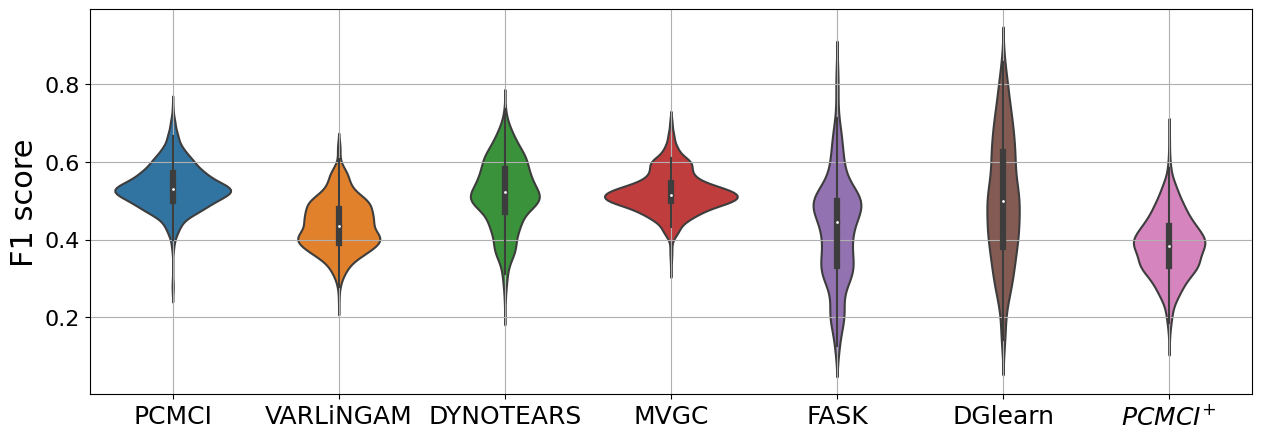

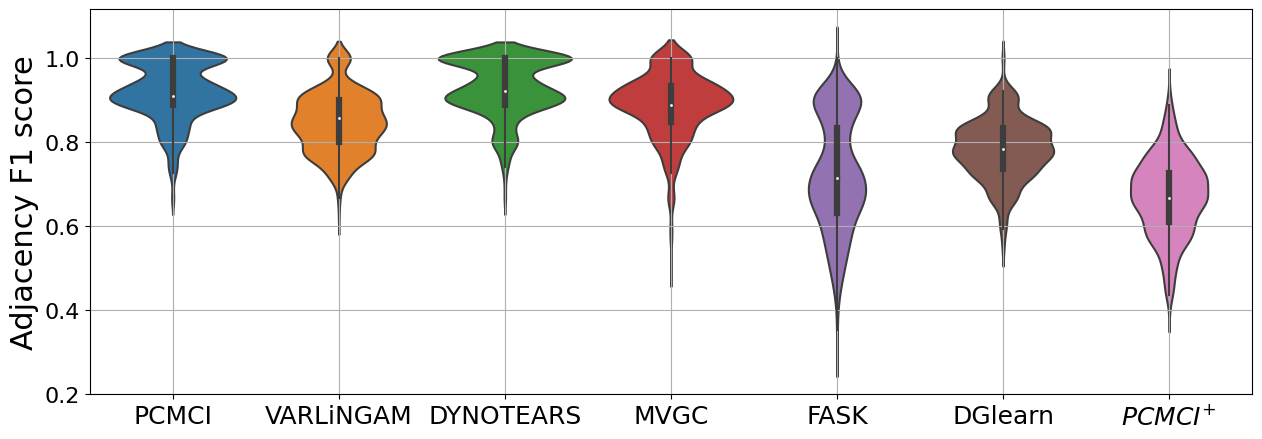

In [33]:
labels = ['PCMCI','VARLiNGAM','DYNOTEARS','MVGC','FASK', 'DGlearn','$PCMCI^{+}$']

fask_all_f1_ori = np.array([])
varlingam_all_f1_ori= np.array([])
dynotears_all_f1_ori= np.array([])
mvgc_all_f1_ori= np.array([])
pcmci_all_f1_ori= np.array([])
dglearn_all_f1_ori= np.array([])
pcmciplus_all_f1_ori= np.array([])

fask_all_f1_adj = np.array([])
varlingam_all_f1_adj = np.array([])
dynotears_all_f1_adj = np.array([])
mvgc_all_f1_adj = np.array([])
pcmci_all_f1_adj = np.array([])
dglearn_all_f1_adj = np.array([])
pcmciplus_all_f1_adj = np.array([])


for n in range(0,num_simple_networks):
    
    fask_all_f1_ori = np.concatenate((fask_all_f1_ori,np.array(fask_ori_F1_score_all_rep[n])[:,np.where(alpha == fask_best_alpha_ori_mean[n][0])[0][0]]))
    varlingam_all_f1_ori = np.concatenate((varlingam_all_f1_ori,np.array(varlingam_ori_F1_score_all_rep[n])[:,np.where(alpha == varlingam_best_alpha_ori_mean[n][0])[0][0]]))
    dynotears_all_f1_ori = np.concatenate((dynotears_all_f1_ori,np.array(dynotears_ori_F1_score_all_rep[n])[:,np.where(alpha_dynotears == dynotears_best_alpha_ori_mean[n][0])[0][0]]))
    mvgc_all_f1_ori = np.concatenate((mvgc_all_f1_ori,np.array(mvgc_ori_F1_score_all_rep[n])[:,np.where(mvgc_alpha == mvgc_best_alpha_ori_mean[n][0])[0][0]]))
    pcmci_all_f1_ori = np.concatenate((pcmci_all_f1_ori,np.array(pcmci_ori_F1_score_all_rep[n])[:,np.where(alpha_level_pcmci == pcmci_best_alpha_ori_mean[n][0])[0][0]]))
    dglearn_all_f1_ori = np.concatenate((dglearn_all_f1_ori,np.array(dglearn_ori_F1_score_all_rep[n])[:,np.where(bic_coef_all == dglearn_best_bic_score_ori_mean[n][0])[0][0]]))
    pcmciplus_all_f1_ori = np.concatenate((pcmciplus_all_f1_ori,np.array(pcmciplus_ori_F1_score_all_rep[n])[:,np.where(pc_alpha_pcmciplus == pcmciplus_best_alpha_ori_mean[n][0])[0][0]]))


    fask_all_f1_adj = np.concatenate((fask_all_f1_adj,np.array(fask_adj_F1_score_all_rep[n])[:,np.where(alpha == fask_best_alpha_ori_mean[n][0])[0][0]]))
    varlingam_all_f1_adj = np.concatenate((varlingam_all_f1_adj,np.array(varlingam_adj_F1_score_all_rep[n])[:,np.where(alpha == varlingam_best_alpha_ori_mean[n][0])[0][0]]))
    dynotears_all_f1_adj = np.concatenate((dynotears_all_f1_adj,np.array(dynotears_adj_F1_score_all_rep[n])[:,np.where(alpha_dynotears == dynotears_best_alpha_ori_mean[n][0])[0][0]]))
    mvgc_all_f1_adj = np.concatenate((mvgc_all_f1_adj,np.array(mvgc_adj_F1_score_all_rep[n])[:,np.where(mvgc_alpha == mvgc_best_alpha_ori_mean[n][0])[0][0]]))
    pcmci_all_f1_adj = np.concatenate((pcmci_all_f1_adj,np.array(pcmci_adj_F1_score_all_rep[n])[:,np.where(alpha_level_pcmci == pcmci_best_alpha_ori_mean[n][0])[0][0]]))
    dglearn_all_f1_adj = np.concatenate((dglearn_all_f1_adj,np.array(dglearn_adj_F1_score_all_rep[n])[:,np.where(bic_coef_all == dglearn_best_bic_score_ori_mean[n][0])[0][0]]))
    pcmciplus_all_f1_adj = np.concatenate((pcmciplus_all_f1_adj,np.array(pcmciplus_adj_F1_score_all_rep[n])[:,np.where(pc_alpha_pcmciplus == pcmciplus_best_alpha_adj_mean[n][0])[0][0]]))

all_methods_f1_ori = [pcmci_all_f1_ori,varlingam_all_f1_ori,dynotears_all_f1_ori,mvgc_all_f1_ori,fask_all_f1_ori, dglearn_all_f1_ori, pcmciplus_all_f1_ori]
all_methods_f1_adj = [pcmci_all_f1_adj,varlingam_all_f1_adj,dynotears_all_f1_adj,mvgc_all_f1_adj,fask_all_f1_adj , dglearn_all_f1_adj, pcmciplus_all_f1_adj]


plt.figure(figsize = (15,5))
ax = plt.subplot()
parts = sb.violinplot(all_methods_f1_ori)

ax.set_xticklabels(labels,fontsize = 18)
plt.yticks(fontsize = 16)
plt.grid()
plt.ylabel('F1 score',fontsize = 22)


plt.figure(figsize = (15,5))
ax = plt.subplot()
parts = sb.violinplot(all_methods_f1_adj)

ax.set_xticklabels(labels,fontsize = 18)
plt.yticks(fontsize = 16)
plt.grid()
plt.ylabel('Adjacency F1 score',fontsize = 22)



##### Statistical Test between distributions of F1 scores for different methods

In [42]:
## F1 score
f1_score_pcmci_dynotears = sp.stats.wilcoxon(pcmci_all_f1_ori, dynotears_all_f1_ori, zero_method='wilcox', alternative='greater', method = "approx")
f1_score_pcmci_varlingam = sp.stats.wilcoxon(pcmci_all_f1_ori, varlingam_all_f1_ori, zero_method='wilcox', alternative='greater', method = "approx")
f1_score_pcmci_mvgc = sp.stats.wilcoxon(pcmci_all_f1_ori, mvgc_all_f1_ori, zero_method='wilcox', alternative='greater', method = "approx")
f1_score_pcmci_fask =  sp.stats.wilcoxon(pcmci_all_f1_ori, fask_all_f1_ori, zero_method='wilcox', alternative='greater', method = "approx")
f1_score_pcmci_dglearn = sp.stats.wilcoxon(pcmci_all_f1_ori, dglearn_all_f1_ori, zero_method='wilcox', alternative='greater', method = "approx")
f1_score_pcmci_pcmciplus = sp.stats.wilcoxon(pcmci_all_f1_ori, pcmciplus_all_f1_ori, zero_method='wilcox', alternative='greater', method = "approx")

## Adjacency F1 score

adj_f1_score_pcmci_dynotears = sp.stats.wilcoxon(pcmci_all_f1_adj, dynotears_all_f1_adj, zero_method='wilcox', alternative='greater', method = "approx")
adj_f1_score_pcmci_varlingam = sp.stats.wilcoxon(pcmci_all_f1_adj, varlingam_all_f1_adj, zero_method='wilcox', alternative='greater', method = "approx")
adj_f1_score_pcmci_mvgc = sp.stats.wilcoxon(pcmci_all_f1_adj, mvgc_all_f1_adj, zero_method='wilcox', alternative='greater', method = "approx")
adj_f1_score_pcmci_fask =  sp.stats.wilcoxon(pcmci_all_f1_adj, fask_all_f1_adj, zero_method='wilcox', alternative='greater', method = "approx")
adj_f1_score_pcmci_dglearn = sp.stats.wilcoxon(pcmci_all_f1_adj, dglearn_all_f1_adj, zero_method='wilcox', alternative='greater', method = "approx")
adj_f1_score_pcmci_pcmciplus = sp.stats.wilcoxon(pcmci_all_f1_adj, pcmciplus_all_f1_adj, zero_method='wilcox', alternative='greater', method = "approx")

print('pcmci-dynotears',f1_score_pcmci_dynotears.zstatistic, f1_score_pcmci_dynotears.pvalue )
print('pcmci-varlingam',f1_score_pcmci_varlingam.zstatistic, f1_score_pcmci_varlingam.pvalue )
print('pcmci-mvgc',f1_score_pcmci_mvgc.zstatistic, f1_score_pcmci_mvgc.pvalue )
print('pcmci-fask',f1_score_pcmci_fask.zstatistic, f1_score_pcmci_fask.pvalue )
print('pcmci-dglearn',f1_score_pcmci_dglearn.zstatistic, f1_score_pcmci_dglearn.pvalue)
print('pcmci-pcmciplus',f1_score_pcmci_pcmciplus.zstatistic, f1_score_pcmci_pcmciplus.pvalue)

print('pcmci-dynotears',adj_f1_score_pcmci_dynotears.zstatistic, adj_f1_score_pcmci_dynotears.pvalue)
print('pcmci-varlingam',adj_f1_score_pcmci_varlingam.zstatistic, adj_f1_score_pcmci_varlingam.pvalue )
print('pcmci-mvgc',adj_f1_score_pcmci_mvgc.zstatistic, adj_f1_score_pcmci_mvgc.pvalue )
print('pcmci-fask',adj_f1_score_pcmci_fask.zstatistic, adj_f1_score_pcmci_fask.pvalue )
print('pcmci-dglearn',adj_f1_score_pcmci_dglearn.zstatistic, adj_f1_score_pcmci_dglearn.pvalue)
print('pcmci-pcmciplus',adj_f1_score_pcmci_pcmciplus.zstatistic, adj_f1_score_pcmci_pcmciplus.pvalue)

pcmci-dynotears 4.114931560978587 1.9364715496996872e-05
pcmci-varlingam 18.628357316208113 9.462194387402871e-78
pcmci-mvgc 8.943212352244865 1.8900919462365978e-19
pcmci-fask 14.077606107366718 2.6073246556330446e-45
pcmci-dglearn 4.975731177957602 3.250090250937419e-07
pcmci-pcmciplus 19.702197817257797 1.032300794858497e-86
pcmci-dynotears -3.046835871317264 0.9988436802572336
pcmci-varlingam 13.581054763880752 2.593699558909558e-42
pcmci-mvgc 11.32159587416386 5.129358692024806e-30
pcmci-fask 17.704587294041186 1.9325171021623945e-70
pcmci-dglearn 18.532772472420483 5.6173195297247625e-77
pcmci-pcmciplus 19.904536678573205 1.8585627439004963e-88


#### Compute the effect sizes

In [39]:
cohens_d_pcmci_dynotears_ori = funcs.compute_cohens_d(pcmci_all_f1_ori,dynotears_all_f1_ori)
cohens_d_pcmci_varlingam_ori = funcs.compute_cohens_d(pcmci_all_f1_ori,varlingam_all_f1_ori)
cohens_d_pcmci_mvgc_ori = funcs.compute_cohens_d(pcmci_all_f1_ori,mvgc_all_f1_ori)
cohens_d_pcmci_fask_ori = funcs.compute_cohens_d(pcmci_all_f1_ori,fask_all_f1_ori)
cohens_d_pcmci_dglean_ori = funcs.compute_cohens_d(pcmci_all_f1_ori,dglearn_all_f1_ori)
cohens_d_pcmci_pcmciplus_ori = funcs.compute_cohens_d(pcmci_all_f1_ori,pcmciplus_all_f1_ori)

cohens_d_pcmci_dynotears_adj = funcs.compute_cohens_d(pcmci_all_f1_adj,dynotears_all_f1_adj)
cohens_d_pcmci_varlingam_adj = funcs.compute_cohens_d(pcmci_all_f1_adj,varlingam_all_f1_adj)
cohens_d_pcmci_mvgc_adj = funcs.compute_cohens_d(pcmci_all_f1_adj,mvgc_all_f1_adj)
cohens_d_pcmci_fask_adj = funcs.compute_cohens_d(pcmci_all_f1_adj,fask_all_f1_adj)
cohens_d_pcmci_dglean_adj = funcs.compute_cohens_d(pcmci_all_f1_adj,dglearn_all_f1_adj)
cohens_d_pcmci_pcmciplus_adj = funcs.compute_cohens_d(pcmci_all_f1_adj,pcmciplus_all_f1_adj)


In [40]:
print('pcmci-dynotears',cohens_d_pcmci_dynotears_ori)
print('pcmci-varlingam',cohens_d_pcmci_varlingam_ori)
print('pcmci-mvgc',cohens_d_pcmci_mvgc_ori)
print('pcmci-fask',cohens_d_pcmci_fask_ori)
print('pcmci-dglearn',cohens_d_pcmci_dglean_ori)
print('pcmci-pcmciplus',cohens_d_pcmci_pcmciplus_ori)

print('pcmci-dynotears',cohens_d_pcmci_dynotears_adj)
print('pcmci-varlingam',cohens_d_pcmci_varlingam_adj)
print('pcmci-mvgc',cohens_d_pcmci_mvgc_adj)
print('pcmci-fask',cohens_d_pcmci_fask_adj)
print('pcmci-dglearn',cohens_d_pcmci_dglean_adj)
print('pcmci-pcmciplus',cohens_d_pcmci_pcmciplus_adj)


pcmci-dynotears 0.22671540306765672
pcmci-varlingam 1.5492000398450037
pcmci-mvgc 0.23765960504720607
pcmci-fask 1.0097192632711138
pcmci-dglearn 0.28473556509925224
pcmci-pcmciplus 2.14083837365908
pcmci-dynotears -0.12634846389430515
pcmci-varlingam 1.0236356428684994
pcmci-mvgc 0.4402953439870973
pcmci-fask 1.830931427420591
pcmci-dglearn 1.9101493633828643
pcmci-pcmciplus 3.0324196912279975
